In [68]:
!pip install scikit-learn
!pip install xgboost lightgbm
!pip install imbalanced-learn
!pip install xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [69]:
!python -m pip install xgboost


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# 라이브러리

In [70]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from datetime import datetime, timedelta
from pytz import timezone
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import (SMOTE, ADASYN)
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, FunctionTransformer)

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 3. accounts_failpaymenthistory 및 15. event_receipts 및 16. events 테이블(총 3개)는 제외함
# 사용자의 경로에 맞게 아래 파라미터를 수정해주시면 됩니다


In [71]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [72]:
# 분류 모델 평가 지표 사용
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# 파일 불러오기

In [73]:
base_path = '/Users/hayechoi/Desktop/DA3/Project_final/database/votes_tables/'

accounts_attendance = pd.read_csv(base_path + 'accounts_attendance.csv') 
accounts_blockrecord = pd.read_csv(base_path + 'accounts_blockrecord.csv')
accounts_friendrequest = pd.read_csv(base_path + 'accounts_friendrequest.csv')
accounts_group = pd.read_csv(base_path + 'accounts_group.csv')
accounts_nearbyschool = pd.read_csv(base_path + 'accounts_nearbyschool.csv')
accounts_paymenthistory = pd.read_csv(base_path + 'accounts_paymenthistory.csv')
accounts_user_contacts = pd.read_csv(base_path + 'accounts_user_contacts.csv')
accounts_pointhistory = pd.read_csv(base_path + 'accounts_pointhistory.csv')
accounts_school = pd.read_csv(base_path + 'accounts_school.csv')
accounts_timelinereport = pd.read_csv(base_path + 'accounts_timelinereport.csv')
accounts_user = pd.read_csv(base_path + 'accounts_user.csv')
accounts_userquestionrecord = pd.read_csv(base_path + 'accounts_userquestionrecord.csv')
accounts_userwithdraw = pd.read_csv(base_path + 'accounts_userwithdraw.csv')

polls_question = pd.read_csv(base_path + 'polls_question.csv')
polls_questionpiece = pd.read_csv(base_path + 'polls_questionpiece.csv')
polls_questionreport = pd.read_csv(base_path + 'polls_questionreport.csv')
polls_questionset = pd.read_csv(base_path + 'polls_questionset.csv')
polls_usercandidate = pd.read_csv(base_path + 'polls_usercandidate.csv')

In [74]:
accounts_attendance.isnull().sum()
accounts_attendance

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453
...,...,...,...
349632,360501,[],897005
349633,360502,"[""2024-05-09""]",1407059
349634,360503,"[""2024-05-09""]",1583727
349635,360504,"[""2024-05-09""]",1392372


In [75]:
accounts_attendance.dropna(inplace=True)

In [76]:
accounts_attendance.isnull().sum()

id                      0
attendance_date_list    0
user_id                 0
dtype: int64

In [77]:
accounts_user.dropna(subset=['gender'], inplace=True)

In [78]:
accounts_userquestionrecord['opened_times'].unique()

array([0, 1, 2, 3])

In [79]:
# 데이터 불러오기

import ast

accounts_attendance["attendance_date_list"] = accounts_attendance["attendance_date_list"].apply(ast.literal_eval)
accounts_attendance = accounts_attendance.explode('attendance_date_list')
accounts_attendance.rename(columns = {"attendance_date_list" : "attendance_date"}, inplace = True)
accounts_attendance = accounts_attendance.reset_index(drop=True)
accounts_attendance

accounts_attendance["attendance_date"] = pd.to_datetime(accounts_attendance["attendance_date"])

# accounts_attendance 컬럼명 변경
accounts_attendance.rename(columns={'attendance_date': 'created_at'}, inplace=True)


# accounts_friendrequest_pcd 컬럼명 변경 
accounts_friendrequest.rename(columns={'send_user_id': 'user_id'}, inplace=True)


accounts_user.rename(columns={'id': 'user_id'}, inplace=True)

dfs = [
    accounts_attendance, accounts_blockrecord, accounts_friendrequest,
    accounts_paymenthistory, accounts_pointhistory, accounts_timelinereport,
    accounts_user, accounts_userquestionrecord
]

# 각 데이터프레임에서 'user_id'와 'created_at' 컬럼만 선택 후 결합
df_combined = pd.concat([df[['user_id', 'created_at']] for df in dfs], ignore_index=True)

In [80]:
# 'created_at'을 datetime 형식으로 변환
df_combined['created_at'] = pd.to_datetime(df_combined['created_at'])

# 2023_05_01부터 데이터 분리

In [81]:
df_combineds = df_combined.copy()
df_combineds

,user_id,created_at
0,1446852,2023-05-27 00:00:00
1,1446852,2023-05-28 00:00:00
2,1446852,2023-05-29 00:00:00
3,1446852,2023-05-30 00:00:00
4,1446852,2023-06-03 00:00:00
...,...,...
23738831,1001607,2024-05-07 11:29:07
23738832,855525,2024-05-08 01:34:56
23738833,855525,2024-05-08 01:35:02
23738834,855525,2024-05-08 01:36:00


In [82]:
# 'created_at'을 datetime 형식으로 변환
df_combineds['created_at'] = pd.to_datetime(df_combineds['created_at'])

In [83]:
# 1. 2023-05-01 이전의 데이터가 있는 user_id 찾기
users_to_remove = df_combineds[df_combineds['created_at'] < '2023-05-01']['user_id'].unique()

# 2. 해당 user_id를 전체 데이터에서 제거
df_filters = df_combineds[~df_combineds['user_id'].isin(users_to_remove)]


# 결과 확인
print(f"제거된 user_id 수: {len(users_to_remove)}")
print(f"남아있는 데이터 크기기: {df_filters.shape}")

제거된 user_id 수: 19092
남아있는 데이터 크기기: (22977245, 2)


In [84]:
df_filters.sort_values(by='created_at')

,user_id,created_at
21863288,862517,2023-05-01 00:00:12.942200
21863289,862518,2023-05-01 00:00:22.647793
2549975,862517,2023-05-01 00:00:26.000000
2549984,862517,2023-05-01 00:00:26.000000
2549983,862517,2023-05-01 00:00:26.000000
...,...,...
2243248,1583711,NaT
2243253,1162275,NaT
2243257,935331,NaT
2243263,1127910,NaT


In [85]:
# user_id별 데이터 개수 계산
user_counts = df_combineds.groupby('user_id').size()

# 값이 1인 user_id 개수
single_entry_count = (user_counts == 1).sum()

# 전체 user_id 개수
total_users = len(user_counts)

percentage = (single_entry_count / total_users) * 100

print(f"값이 1인 user_id 개수: {single_entry_count}")
print(f"전체 대비 비율: {percentage:.2f}%")


값이 1인 user_id 개수: 23476
전체 대비 비율: 3.47%


In [86]:
# 'created_at'에서 날짜만 추출하여 새로운 컬럼 생성
df_filters['date'] = df_filters['created_at'].dt.date

# user_id별 고유 접속 날짜 수 계산
df_usage_dayss = df_filters.groupby('user_id')['date'].nunique().reset_index()

# 컬럼명 변경
df_usage_dayss.rename(columns={'date': 'total_using_days'}, inplace=True)

/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/10367259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filters['date'] = df_filters['created_at'].dt.date


In [87]:
df_usage_dayss.sort_values(by='total_using_days', ascending=False)

,user_id,total_using_days
579870,1499325,312
413465,1314665,304
551155,1467385,279
551008,1467221,276
572446,1491003,276
...,...,...
368446,1265471,1
368451,1265476,1
368452,1265477,1
368457,1265482,1


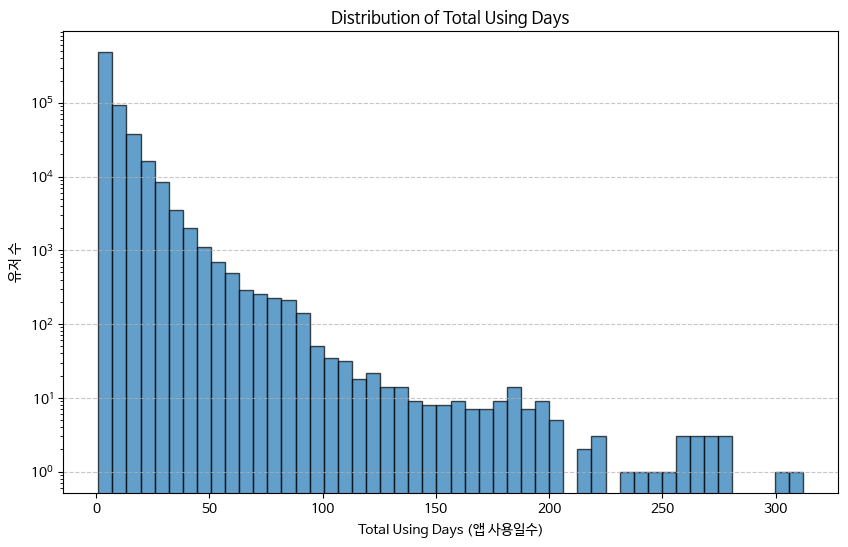

In [88]:

plt.figure(figsize=(10, 6))
plt.hist(df_usage_dayss['total_using_days'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Total Using Days (앱 사용일수)')
plt.ylabel('유저 수')
plt.title('Distribution of Total Using Days')
plt.yscale('log')  # y축을 로그 스케일로 변환 (극단값 영향 최소화)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 출력
plt.show()


# 구매 포인트 기록

In [89]:
accounts_paymenthistory

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081
...,...,...,...,...,...
95135,98074,heart.777,I,2024-05-06 14:51:27,1086654
95136,98075,heart.1000,I,2024-05-06 16:06:30,871740
95137,98076,heart.1000,I,2024-05-08 06:57:23,1166361
95138,98077,heart.1000,I,2024-05-08 14:12:45,1163480


In [90]:
accounts_paymenthistory.duplicated().sum()

np.int64(0)

In [91]:
accounts_paymenthistory = accounts_paymenthistory.drop_duplicates()

In [92]:
accounts_paymenthistory.duplicated().sum()

np.int64(0)

In [93]:
# productId 컬럼에서 숫자 부분만 추출하여 int 타입으로 변환
accounts_paymenthistory['productId'] = accounts_paymenthistory['productId'].str.extract('(\d+)').astype(int)
accounts_paymenthistory['productId'] 

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/3450675330.py:2: SyntaxWarning: invalid escape sequence '\d'
  accounts_paymenthistory['productId'] = accounts_paymenthistory['productId'].str.extract('(\d+)').astype(int)


0         777
1         777
2         777
3         777
4         777
         ... 
95135     777
95136    1000
95137    1000
95138    1000
95139    1000
Name: productId, Length: 95140, dtype: int64

In [94]:
accounts_paymenthistory = accounts_paymenthistory.drop(columns='id')
accounts_paymenthistory

,productId,phone_type,created_at,user_id
0,777,A,2023-05-13 21:28:34,1211127
1,777,A,2023-05-13 21:29:39,1151343
2,777,A,2023-05-13 21:31:33,1002147
3,777,A,2023-05-13 21:31:39,1095040
4,777,A,2023-05-13 21:34:32,1164081
...,...,...,...,...
95135,777,I,2024-05-06 14:51:27,1086654
95136,1000,I,2024-05-06 16:06:30,871740
95137,1000,I,2024-05-08 06:57:23,1166361
95138,1000,I,2024-05-08 14:12:45,1163480


In [95]:
accounts_paymenthistory.duplicated().sum()

np.int64(531)

In [96]:
accounts_paymenthistory= accounts_paymenthistory.drop_duplicates()
accounts_paymenthistory.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94609 entries, 0 to 95138
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   productId   94609 non-null  int64 
 1   phone_type  94609 non-null  object
 2   created_at  94609 non-null  object
 3   user_id     94609 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.6+ MB


In [97]:
# 각 user_id별로 productId 총합 계산
df_grouped_sum = accounts_paymenthistory.groupby('user_id')['productId'].sum().reset_index()

df_grouped_sum.columns = ['user_id', 'point_sum']


In [98]:
df_grouped_sum 

,user_id,point_sum
0,833041,8000
1,834112,777
2,835815,1177
3,835839,777
4,835888,977
...,...,...
59187,1583408,2331
59188,1583445,200
59189,1583450,777
59190,1583454,1554


In [99]:
# user_id별 구매 횟수(count)
user_purchase_counts = accounts_paymenthistory.groupby('user_id')['productId'].count().reset_index()

# 컬럼명 변경
user_purchase_counts.columns = ['user_id', 'purchase_count']
user_purchase_counts


,user_id,purchase_count
0,833041,2
1,834112,1
2,835815,3
3,835839,1
4,835888,2
...,...,...
59187,1583408,3
59188,1583445,1
59189,1583450,1
59190,1583454,2


# 친구 요청 수

In [100]:
accounts_friendrequest

,id,status,created_at,updated_at,receive_user_id,user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521
...,...,...,...,...,...,...
17147170,19692975,P,2024-05-09 07:24:50,2024-05-09 07:24:50,1583730,1583731
17147171,19692976,A,2024-05-09 07:31:41,2024-05-09 07:33:06,1583731,1583673
17147172,19692977,P,2024-05-09 08:20:44,2024-05-09 08:20:44,1299129,1575671
17147173,19692978,R,2024-05-09 09:19:40,2024-05-09 09:19:43,1304403,1392729


In [101]:
# id컬럼 제거
accounts_friendrequest = accounts_friendrequest.drop(columns='id')

In [102]:
accounts_friendrequest.duplicated().sum()

np.int64(63)

In [103]:
accounts_friendrequest = accounts_friendrequest.drop_duplicates()

In [104]:
# 컬럼명 변경
accounts_friendrequest.rename(columns={'send_user_id': 'user_id'}, inplace=True)

# 변경된 데이터 확인
accounts_friendrequest.head()

,status,created_at,updated_at,receive_user_id,user_id
0,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521


In [105]:
send = accounts_friendrequest.groupby('user_id').size().reset_index(name='request_count')
send

,user_id,request_count
0,831962,1
1,832151,10
2,832340,26
3,833024,2
4,833041,35
...,...,...
649067,1583726,50
649068,1583728,5
649069,1583730,20
649070,1583731,1


# 마스터 테이블 만들기

In [106]:
# df_usage_dayss와 df_grouped_sum (accounts_paymenthistory) LEFT JOIN(총 사용일수 및 포인트 합계)
df_merged = df_usage_dayss.merge(df_grouped_sum, on='user_id', how='left')

# 결측값을 0으로
df_merged.fillna(0, inplace=True)

In [107]:
# df_merged와 accounts_friendrequest(친구 요청수)
df_merged = df_merged.merge(send, on='user_id', how='left').fillna(0)

df_merged

,user_id,total_using_days,point_sum,request_count
0,855179,1,0.0,0.0
1,862517,3,0.0,14.0
2,862518,3,0.0,16.0
3,862519,9,0.0,29.0
4,862520,5,0.0,19.0
...,...,...,...,...
657986,1583729,1,0.0,0.0
657987,1583730,1,0.0,20.0
657988,1583731,1,0.0,1.0
657989,1583732,1,0.0,3.0


# 3팀 클러스터링 진행 방식 (기존안)

In [108]:
# user_id는 제외하고 수치형 컬럼의 왜도 계산
skew_values = df_merged.drop(columns='user_id').skew()
skew_values

total_using_days     5.896748
point_sum           22.337908
request_count        6.164100
dtype: float64

- 3개 변수 모두 비대칭 형태를 지님

In [109]:
# 원본 복사
df_log = df_merged.copy()

# 로그 변환 적용: log(1 + x)
cols_to_transform = ['total_using_days', 'point_sum', 'request_count']
for col in cols_to_transform:
    df_log[col] = np.log1p(df_log[col])

df_log[cols_to_transform].skew()

total_using_days    0.645622
point_sum           2.936333
request_count      -0.955475
dtype: float64

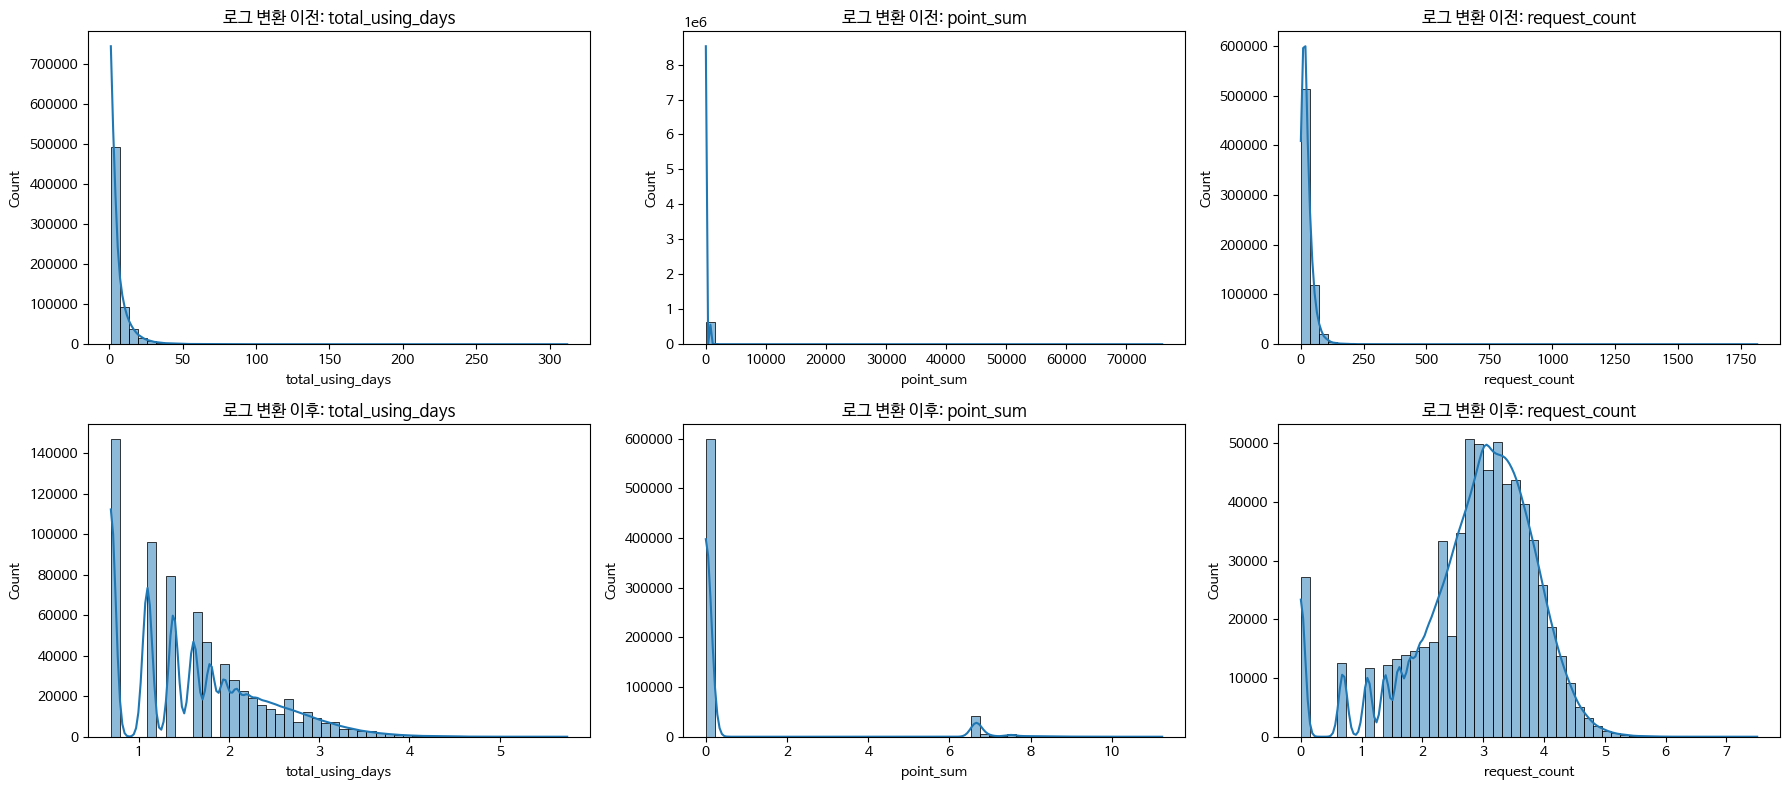

In [110]:
plt.figure(figsize=(18, 8))
for i, col in enumerate(cols_to_transform):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_merged[col], kde=True, bins=50)
    plt.title(f"로그 변환 이전: {col}")
    
    plt.subplot(2, 3, i+4)
    sns.histplot(df_log[col], kde=True, bins=50)
    plt.title(f"로그 변환 이후: {col}")
    
plt.tight_layout()
plt.show()


In [111]:
# 각 컬럼별로 0 이하 값이 몇 개인지 확인
(df_log[cols_to_transform] <= 0).sum()

total_using_days         0
point_sum           599711
request_count        27184
dtype: int64

## 로버스트 스케일링

In [112]:
from sklearn.preprocessing import RobustScaler

# RobustScaler 적용
scaler = RobustScaler()
X_robust = scaler.fit_transform(df_log[cols_to_transform])

# 결과를 DataFrame으로 저장
df_robust = pd.DataFrame(X_robust, columns=cols_to_transform)

# 스케일링 후 기초통계량 확인
robust_stats = df_robust.describe()
robust_stats


,total_using_days,point_sum,request_count
count,657991.000000,657991.000000,657991.000000
mean,0.015953,0.612552,-0.144446
std,0.785521,1.971724,0.877950
min,-0.934200,0.000000,-2.630364
25%,-0.520810,0.000000,-0.558664
50%,0.000000,0.000000,0.000000
75%,0.479190,0.000000,0.441336
max,4.217620,11.238199,3.853651


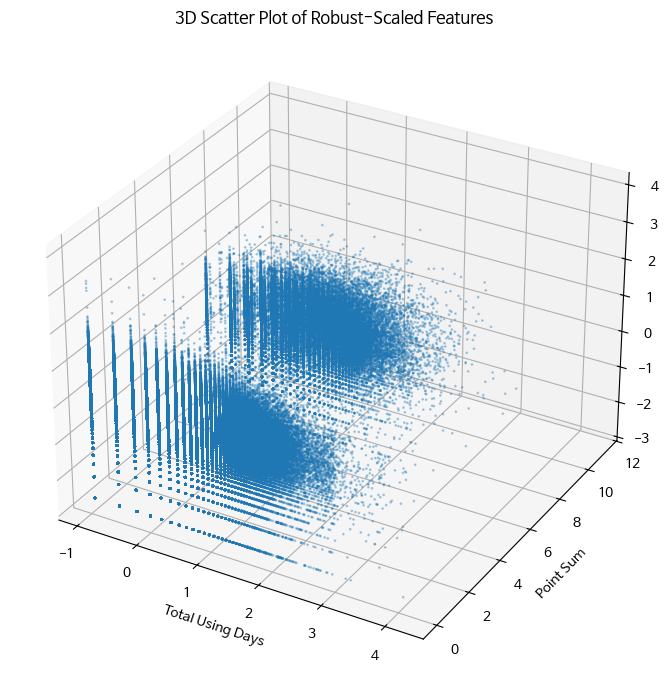

In [113]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    df_robust['total_using_days'],
    df_robust['point_sum'],
    df_robust['request_count'],
    alpha=0.3,
    s=1
)

ax.set_xlabel('Total Using Days')
ax.set_ylabel('Point Sum')
ax.set_zlabel('Request Count')
ax.set_title('3D Scatter Plot of Robust-Scaled Features')
plt.tight_layout()
plt.show()


- 클러스터처럼 보이는 응집 구조가 보이긴 하지만, 아주 뚜렷하진 않음

- 이는 KMeans의 효과가 제한될 수 있음을 시사함 (KMeans는 원형 클러스터에 강함)

- GMM(가우시안 혼합 모델)이 더 나은 결과를 줄 수 있음 (타원형 군집 대응 가능)

## KMeans 클러스터링

In [114]:
# 라이브러리 불러오기
from sklearn.cluster import KMeans


# inertia 값을 저장할 리스트
inertias = []

for k in range(1,10): # k값의 범위를 1~9로 지정
    model = KMeans(n_clusters=k, random_state=123)
    model.fit(df_robust)
    inertias.append(model.inertia_)

<Axes: >

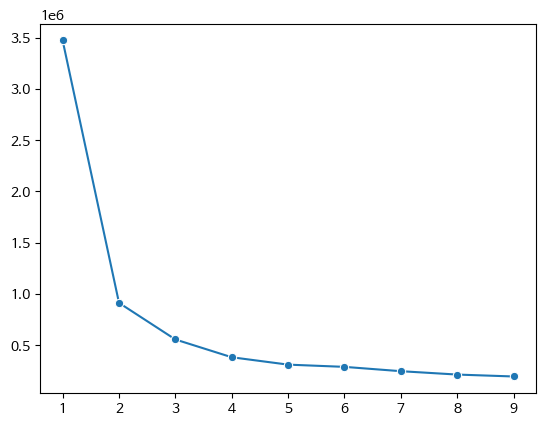

In [115]:
# k값에 따른 inertia 시각화
sns.lineplot(x=range(1,10), y=inertias, marker='o')

In [116]:
df_robust_a = df_robust.copy()

In [117]:
from sklearn.cluster import KMeans

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(df_robust_a)

# 클러스터 라벨을 데이터프레임에 추가
df_robust_a['kmeans_cluster'] = kmeans_labels

# 클러스터별 통계 요약
kmeans_summary = df_robust_a.groupby('kmeans_cluster').mean(numeric_only=True)

# 클러스터별 개수 추가
kmeans_summary['count'] = df_robust_a['kmeans_cluster'].value_counts().sort_index()

kmeans_summary


,total_using_days,point_sum,request_count,count
kmeans_cluster,,,,
0,0.867221,0.000000,0.289148,197827
1,-0.417106,0.000000,0.049687,299647
2,0.489954,6.915814,0.077530,58280
3,-0.632183,0.000000,-1.678968,102237


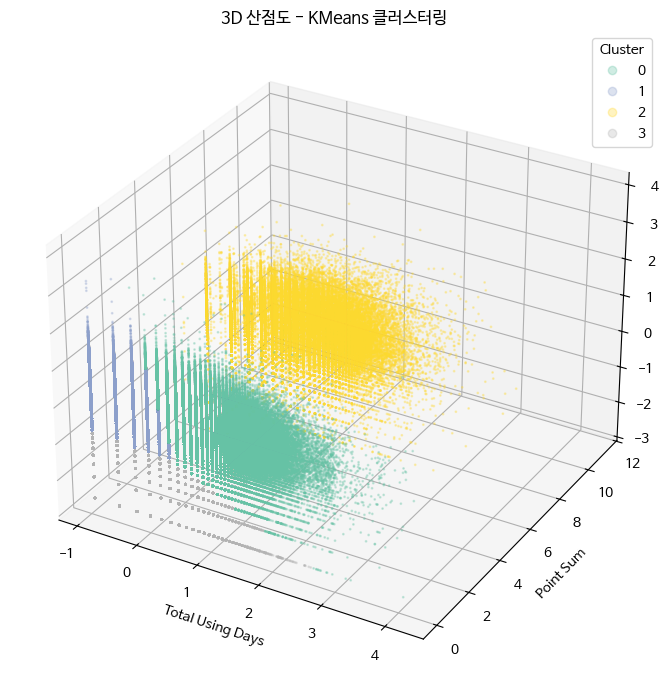

In [118]:
# 3D 시각화 (kmeans 클러스터 결과 포함)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_robust_a['total_using_days'],
    df_robust_a['point_sum'],
    df_robust_a['request_count'],
    c=df_robust_a['kmeans_cluster'],
    cmap='Set2',
    alpha=0.3,
    s=1
)

ax.set_xlabel('Total Using Days')
ax.set_ylabel('Point Sum')
ax.set_zlabel('Request Count')
ax.set_title('3D 산점도 - KMeans 클러스터링')

plt.legend(*scatter.legend_elements(), title='Cluster')
plt.tight_layout()
plt.show()


- KMeans는 거리 기반 군집화이므로, Cluster 2와 나머지 군집 간 거리 차이가 매우 커서 중심을 잘 나눴음

- 그러나 왼쪽 세 군집은 거리가 가까워서 KMeans가 구분하기 어려운 상황

In [119]:
# 강의식 실루엣 계수 구하기기
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# 샘플링 
sampled_df = df_robust_a.sample(n=10000, random_state=42)

# 실루엣 점수 계산
kmeans_score = silhouette_score(
    sampled_df.drop(columns='kmeans_cluster'),  # 피처만
    sampled_df['kmeans_cluster']                # 클러스터 라벨
)

print("k-means 실루엣 계수 (샘플 10,000개):", kmeans_score)


k-means 실루엣 계수 (샘플 10,000개): 0.4208172060096328


In [120]:
# GPT식 실루엣 계수 구하기기

from sklearn.metrics import silhouette_score
from sklearn.utils import resample

# 샘플링 (10,000개) 후 실루엣 점수 계산
X_sample, label_sample = resample(
    df_robust_a[cols_to_transform],
    df_robust_a['kmeans_cluster'],
    n_samples=10000,
    random_state=42
)

kmeans_silhouette = silhouette_score(X_sample, label_sample)
kmeans_silhouette


np.float64(0.4246668631134496)

## GMM

In [121]:
df_robust_b = df_robust.copy()

In [122]:
from sklearn.mixture import GaussianMixture

# GMM 클러스터링
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(df_robust_b[cols_to_transform])
df_robust_b['gmm_cluster'] = gmm_labels

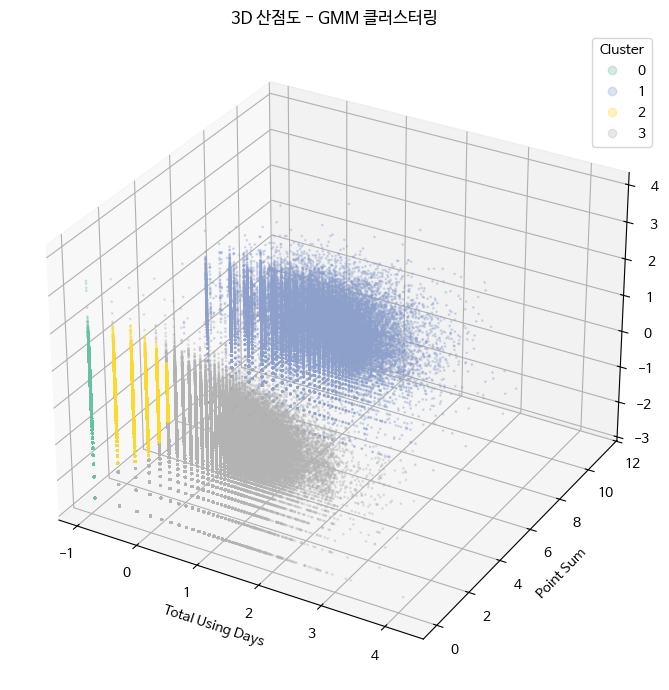

In [123]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_robust_b['total_using_days'],
    df_robust_b['point_sum'],
    df_robust_b['request_count'],
    c=df_robust_b['gmm_cluster'],
    cmap='Set2',
    alpha=0.3,
    s=1
)

ax.set_xlabel('Total Using Days')
ax.set_ylabel('Point Sum')
ax.set_zlabel('Request Count')
ax.set_title('3D 산점도 - GMM 클러스터링')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.tight_layout()
plt.show()


In [124]:
# 강의식 실루엣 계수 구하기

from sklearn.metrics import silhouette_score

# 샘플링 (10,000개)
sampled_df = df_robust_b.sample(n=20000, random_state=42)

# 실루엣 점수 계산
gmm_score = silhouette_score(
    sampled_df.drop(columns='gmm_cluster'),  # 피처만
    sampled_df['gmm_cluster']                # 클러스터 라벨
)

print("GMM 실루엣 계수 :", gmm_score)


GMM 실루엣 계수 : 0.29132912996051663


In [125]:
# GPT식 실루엣 계수 구하기하기

from sklearn.mixture import GaussianMixture


# 샘플링하여 실루엣 점수 계산
X_sample_gmm, label_sample_gmm = resample(
    df_robust_b[cols_to_transform],
    df_robust_b['gmm_cluster'],
    n_samples=100000,
    random_state=42
)
gmm_silhouette = silhouette_score(X_sample_gmm, label_sample_gmm)
gmm_silhouette


np.float64(0.2883463690736144)

- 샘플 개수 10,000 -> 실루엣 점수 0.29001
- 샘플 개수 20,000 -> 실루엣 점수 0.28752
- 샘플 개수 30,000 -> 실루엣 점수 0.28900
- 샘플 개수 40,000 -> 실루엣 점수 0.29002
- 샘플 개수 100,000 -> 실루엣 점수 0.28834

## 예측모델

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# 1. Feature/Target 분리
X = df_robust_a.drop(columns='kmeans_cluster')
y = df_robust_a['kmeans_cluster']

In [127]:
# 2. 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 3. 모델 학습
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 4. 예측 및 평가
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39566
           1       1.00      1.00      1.00     59930
           2       1.00      1.00      1.00     11656
           3       1.00      1.00      1.00     20447

    accuracy                           1.00    131599
   macro avg       1.00      1.00      1.00    131599
weighted avg       1.00      1.00      1.00    131599



In [128]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
print("5-Fold CV F1 평균 점수:", np.mean(scores))

5-Fold CV F1 평균 점수: 0.9999984802283496


In [133]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd

# Feature, Target 분리
X = df_robust_a.drop(columns='kmeans_cluster')
y = df_robust_a['kmeans_cluster']

# 모델 정의
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', objective='multi:softmax', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# 교차검증 설정
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# f1_weighted 기준 성능 측정
cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kfold, scoring='f1_weighted')
    cv_results[model_name] = np.round(scores.mean(), 4)

# 결과 DataFrame으로 정리
cv_df = pd.DataFrame.from_dict(cv_results, orient='index', columns=['f1_weighted_score'])
cv_df.sort_values(by='f1_weighted_score', ascending=False, inplace=True)

cv_df


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 467
[LightGBM] [Info] Number of data points in the train set: 526392, number of used features: 3
[LightGBM] [Info] Start training from score -1.201820
[LightGBM] [Info] Start training from score -0.785724
[LightGBM] [Info] Start training from score -2.423673
[LightGBM] [Info] Start training from score -1.864536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

,f1_weighted_score
Decision Tree,1.0000
Random Forest,1.0000
LightGBM,1.0000
XGBoost,0.9999
AdaBoost,0.9867


In [134]:
from imblearn.over_sampling import SMOTE

# SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 교차검증: SMOTE 적용된 데이터로 f1_weighted 성능 측정
cv_results_smote = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_resampled, y_resampled, cv=kfold, scoring='f1_weighted')
    cv_results_smote[model_name] = np.round(scores.mean(), 4)

# 결과 정리
cv_df_smote = pd.DataFrame.from_dict(cv_results_smote, orient='index', columns=['f1_weighted_score_smote'])
cv_df_smote.sort_values(by='f1_weighted_score_smote', ascending=False, inplace=True)

cv_df_smote


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 958870, number of used features: 3
[LightGBM] [Info] Start training from score -1.386150
[LightGBM] [Info] Start training from score -1.386935
[LightGBM] [Info] Start training from score -1.384942
[LightGBM] [Info] Start training from score -1.387152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

,f1_weighted_score_smote
Decision Tree,1.0000
Random Forest,1.0000
XGBoost,1.0000
LightGBM,1.0000
AdaBoost,0.9601


## Feature importance

In [135]:
#feature importance 수치화
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Feature importance 추출
rf_importances = rf_model.feature_importances_
rf_df = pd.DataFrame({
    'feature': X.columns,
    'importance': np.round(rf_importances, 4)
}).sort_values(by='importance', ascending=False)

rf_df


,feature,importance
0,total_using_days,0.4681
2,request_count,0.3329
1,point_sum,0.1990


In [136]:
from sklearn.ensemble import RandomForestClassifier

# 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Feature importance 추출
rf_importances = rf_model.feature_importances_

# 가중치 normalize (합 = 1)
rf_weights = rf_importances / rf_importances.sum()

# 가중합 기반 PTF 점수 계산
df_robust['PTF_score_RF'] = (
    rf_weights[0] * df_robust['point_sum'] +
    rf_weights[1] * df_robust['total_using_days'] +
    rf_weights[2] * df_robust['request_count']
)

# 가중치와 함께 결과 확인
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_importances,
    'normalized_weight': rf_weights
})

importance_df


,feature,importance,normalized_weight
0,total_using_days,0.468122,0.468122
1,point_sum,0.198995,0.198995
2,request_count,0.332883,0.332883


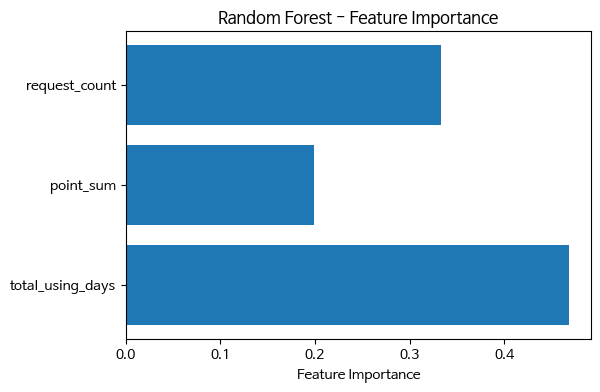

In [137]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


model = RandomForestClassifier(random_state=42)
model.fit(X, y)


importances = model.feature_importances_
features = X.columns


plt.figure(figsize=(6, 4))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest - Feature Importance")
plt.show()


In [138]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X, y)

dt_importances = dt_model.feature_importances_
dt_df = pd.DataFrame({
    'feature': X.columns,
    'importance': np.round(dt_importances, 4)
}).sort_values(by='importance', ascending=False)

dt_df


,feature,importance
0,total_using_days,0.4212
2,request_count,0.3550
1,point_sum,0.2238


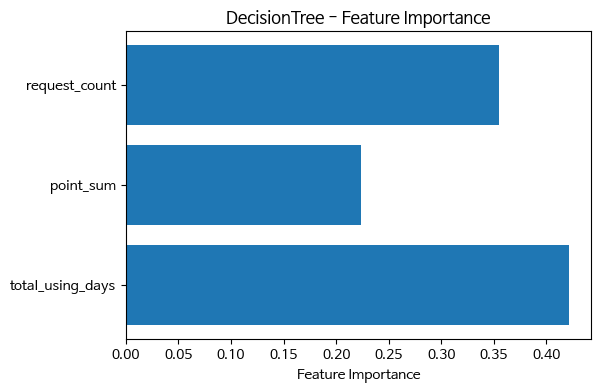

In [139]:
plt.figure(figsize=(6, 4))
plt.barh(features, dt_importances)
plt.xlabel("Feature Importance")
plt.title("DecisionTree - Feature Importance")
plt.show()


In [140]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='mlogloss', objective='multi:softmax', random_state=42)
xgb_model.fit(X, y)

xgb_importances = xgb_model.feature_importances_
xgb_df = pd.DataFrame({
    'feature': X.columns,
    'importance': np.round(xgb_importances, 4)
}).sort_values(by='importance', ascending=False)

xgb_df


,feature,importance
1,point_sum,0.6284
0,total_using_days,0.2120
2,request_count,0.1596


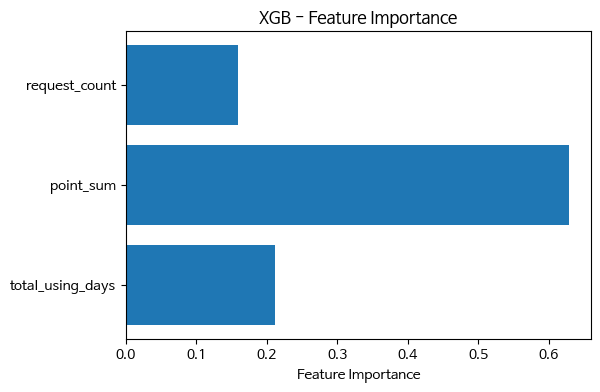

In [141]:
plt.figure(figsize=(6, 4))
plt.barh(features, xgb_importances)
plt.xlabel("Feature Importance")
plt.title("XGB - Feature Importance")
plt.show()


In [142]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X, y)

lgb_importances = lgb_model.booster_.feature_importance(importance_type='gain')  # ← 여기!
lgb_df = pd.DataFrame({
    'feature': X.columns,
    'importance': np.round(lgb_importances, 4)
}).sort_values(by='importance', ascending=False)

lgb_df


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 657991, number of used features: 3
[LightGBM] [Info] Start training from score -1.201798
[LightGBM] [Info] Start training from score -0.786586
[LightGBM] [Info] Start training from score -2.423932
[LightGBM] [Info] Start training from score -1.861898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

,feature,importance
0,total_using_days,3.193799e+06
2,request_count,3.137589e+06
1,point_sum,2.251109e+06


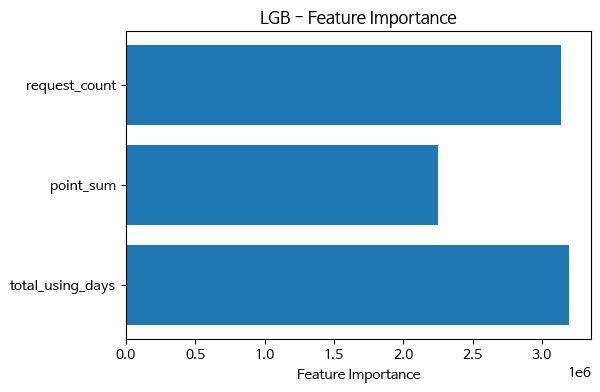

In [143]:
plt.figure(figsize=(6, 4))
plt.barh(features, lgb_importances)
plt.xlabel("Feature Importance")
plt.title("LGB - Feature Importance")
plt.show()


## 3점 척도 기반 평가 점수

In [144]:
df_robust_pp = df_robust_a.copy()

In [145]:
from sklearn.ensemble import RandomForestClassifier

# 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Feature importance 추출
rf_importances = rf_model.feature_importances_

# 가중치 normalize (합 = 1)
rf_weights = rf_importances / rf_importances.sum()

# 가중합 기반 PTF 점수 계산
df_robust_pp['PTF_score_RF'] = (
    rf_weights[0] * df_robust_pp['point_sum'] +
    rf_weights[1] * df_robust_pp['total_using_days'] +
    rf_weights[2] * df_robust_pp['request_count']
)

df_robust_pp

,total_using_days,point_sum,request_count,kmeans_cluster,PTF_score_RF
0,-0.934200,0.0,-2.630364,3,-1.061504
1,-0.227505,0.0,-0.290701,1,-0.142042
2,-0.227505,0.0,-0.182564,1,-0.106045
3,0.706695,0.0,0.308155,0,0.243209
4,0.185885,0.0,-0.042153,1,0.022958
...,...,...,...,...,...
657986,-0.934200,0.0,-2.630364,3,-1.061504
657987,-0.934200,0.0,0.000000,1,-0.185902
657988,-0.934200,0.0,-2.031509,3,-0.862155
657989,-0.934200,0.0,-1.432653,3,-0.662807


In [146]:
# 3점 척도 점수화 함수
def quantile_score_3pt(series):
    try:
        return pd.qcut(series, q=3, labels=[1, 2, 3])
    except ValueError:
        return pd.Series([1]*len(series), index=series.index)

# 3점 척도 점수 부여
for col in cols_to_transform:
    df_robust_pp[f"{col}_score"] = quantile_score_3pt(df_robust_pp[col]).astype(int)

# PTF 점수 계산 (3점 기반: 최대 9점)
df_robust_pp['PTF_score_3pt'] = (
    df_robust_pp['point_sum_score'] +
    df_robust_pp['total_using_days_score'] +
    df_robust_pp['request_count_score']
)

df_robust_pp

,total_using_days,point_sum,request_count,kmeans_cluster,PTF_score_RF,total_using_days_score,point_sum_score,request_count_score,PTF_score_3pt
0,-0.934200,0.0,-2.630364,3,-1.061504,1,1,1,3
1,-0.227505,0.0,-0.290701,1,-0.142042,2,1,2,5
2,-0.227505,0.0,-0.182564,1,-0.106045,2,1,2,5
3,0.706695,0.0,0.308155,0,0.243209,3,1,3,7
4,0.185885,0.0,-0.042153,1,0.022958,2,1,2,5
...,...,...,...,...,...,...,...,...,...
657986,-0.934200,0.0,-2.630364,3,-1.061504,1,1,1,3
657987,-0.934200,0.0,0.000000,1,-0.185902,1,1,2,4
657988,-0.934200,0.0,-2.031509,3,-0.862155,1,1,1,3
657989,-0.934200,0.0,-1.432653,3,-0.662807,1,1,1,3


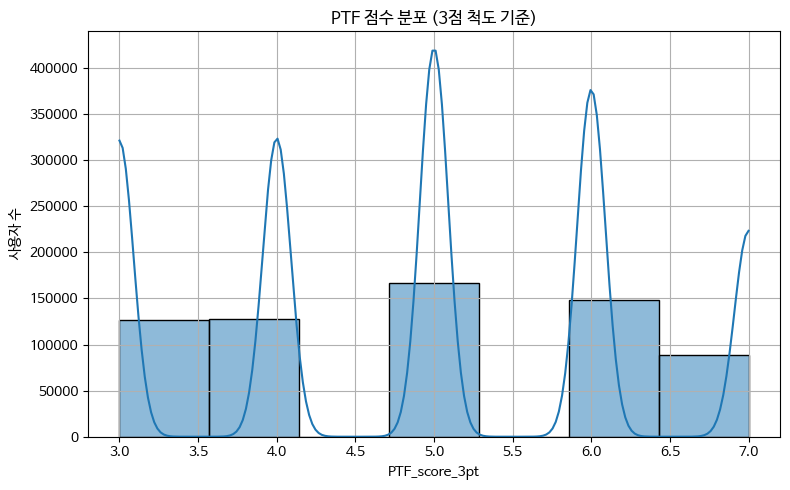

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_robust_pp['PTF_score_3pt'], bins=7, kde=True)
plt.title('PTF 점수 분포 (3점 척도 기준)')
plt.xlabel('PTF_score_3pt')
plt.ylabel('사용자 수')
plt.grid(True)
plt.tight_layout()
plt.show()


## point_sum > 0인 유저만 필터링

In [148]:
df_filtered = df_robust_pp [df_robust_pp ['point_sum'] > 0].copy()

# 사용할 컬럼
features = ['point_sum', 'total_using_days', 'request_count']

# 분위수 기반 점수화 함수 (3점 척도용)
def quantile_score_3pt(series):
    try:
        return pd.qcut(series, q=3, labels=[1, 2, 3])
    except ValueError:
        return pd.Series([1]*len(series), index=series.index)

# 각 변수에 대해 3점 척도 점수 부여
for col in features:
    df_filtered[f"{col}_score"] = quantile_score_3pt(df_filtered[col]).astype(int)

# 총 PTF 점수 계산
df_filtered['PTF_score_3pt'] = (
    df_filtered['point_sum_score'] +
    df_filtered['total_using_days_score'] +
    df_filtered['request_count_score']
)

df_filtered

,total_using_days,point_sum,request_count,kmeans_cluster,PTF_score_RF,total_using_days_score,point_sum_score,request_count_score,PTF_score_3pt
32,0.000000,6.656727,0.000000,2,3.116160,1,1,2,4
76,0.479190,6.656727,0.336484,2,3.323526,2,1,2,5
119,0.599275,8.294300,0.150635,2,4.052141,2,1,2,5
123,1.120085,6.656727,0.658463,2,3.558243,3,1,3,7
139,0.892580,6.656727,0.783376,2,3.554552,3,1,3,7
...,...,...,...,...,...,...,...,...,...
657666,-0.227505,7.754482,-1.082345,2,3.224477,1,1,1,3
657703,0.599275,5.303305,0.677452,2,2.827359,2,1,3,6
657708,-0.227505,6.656727,0.363914,2,3.192028,1,1,2,4
657712,-0.520810,7.349231,0.336484,2,3.448708,1,1,2,4


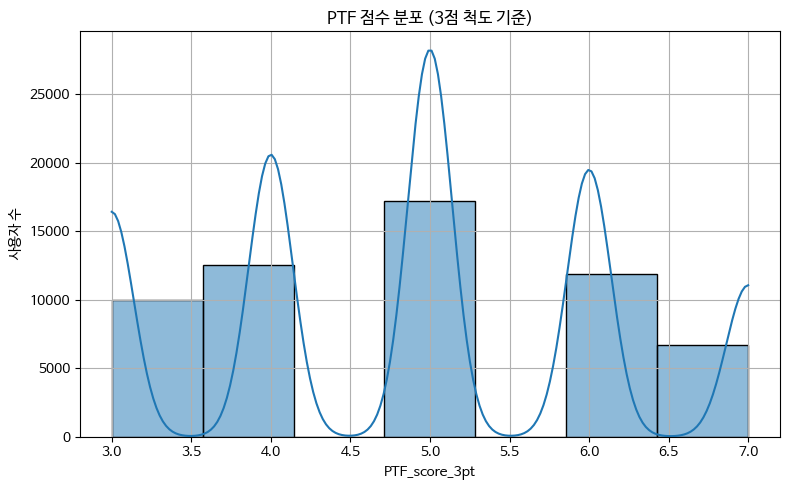

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_filtered['PTF_score_3pt'], bins=7, kde=True)
plt.title('PTF 점수 분포 (3점 척도 기준)')
plt.xlabel('PTF_score_3pt')
plt.ylabel('사용자 수')
plt.grid(True)
plt.tight_layout()
plt.show()

In [150]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_cluster = df_filtered[['point_sum_score', 'total_using_days_score', 'request_count_score']]

# 최적 클러스터 수 탐색 (옵션)
for k in range(2, 7):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_cluster)
    score = silhouette_score(X_cluster, labels)
    print(f"k={k}, 실루엣 점수: {score:.4f}")




k=2, 실루엣 점수: 0.4297
k=3, 실루엣 점수: 0.4600
k=4, 실루엣 점수: 0.4824
k=5, 실루엣 점수: 0.5935
k=6, 실루엣 점수: 0.6638


In [151]:
# k=6으로 모델 적용 예시
kmeans = KMeans(n_clusters=6, random_state=42)
df_filtered['kmeans_cluster'] = kmeans.fit_predict(X_cluster)

In [152]:
df_filtered['kmeans_cluster'].value_counts()

kmeans_cluster
1    19746
4     9987
2     9969
0     6726
5     5972
3     5880
Name: count, dtype: int64

## 5점 척도 기반 평가점수

- 위에 3점 척도 기반 평가 점수 코드와 동일하기에 아래부터는 df_robust_pp를 다시 실행해주어야 함

In [153]:
from sklearn.ensemble import RandomForestClassifier

# 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Feature importance 추출
rf_importances = rf_model.feature_importances_

# 가중치 normalize (합 = 1)
rf_weights = rf_importances / rf_importances.sum()

# 가중합 기반 PTF 점수 계산
df_robust_pp['PTF_score_RF'] = (
    rf_weights[0] * df_robust_pp['point_sum'] +
    rf_weights[1] * df_robust_pp['total_using_days'] +
    rf_weights[2] * df_robust_pp['request_count']
)

df_robust_pp


,total_using_days,point_sum,request_count,kmeans_cluster,PTF_score_RF,total_using_days_score,point_sum_score,request_count_score,PTF_score_3pt
0,-0.934200,0.0,-2.630364,3,-1.061504,1,1,1,3
1,-0.227505,0.0,-0.290701,1,-0.142042,2,1,2,5
2,-0.227505,0.0,-0.182564,1,-0.106045,2,1,2,5
3,0.706695,0.0,0.308155,0,0.243209,3,1,3,7
4,0.185885,0.0,-0.042153,1,0.022958,2,1,2,5
...,...,...,...,...,...,...,...,...,...
657986,-0.934200,0.0,-2.630364,3,-1.061504,1,1,1,3
657987,-0.934200,0.0,0.000000,1,-0.185902,1,1,2,4
657988,-0.934200,0.0,-2.031509,3,-0.862155,1,1,1,3
657989,-0.934200,0.0,-1.432653,3,-0.662807,1,1,1,3


In [154]:
# 분위수 기반 점수화 함수 (5점 척도)
def quantile_score_5pt(series):
    try:
        return pd.qcut(series, q=5, labels=[1, 2, 3, 4, 5])
    except ValueError:
        return pd.Series([1]*len(series), index=series.index)

# 각 변수에 대해 5점 점수 부여
for col in features:
    df_robust_pp[f"{col}_score"] = quantile_score_5pt(df_robust_pp[col]).astype(int)

# 총합 점수 계산
df_robust_pp['PTF_score_5pt'] = (
    df_robust_pp['point_sum_score'] +
    df_robust_pp['total_using_days_score'] +
    df_robust_pp['request_count_score']
)

df_robust_pp

,total_using_days,point_sum,request_count,kmeans_cluster,PTF_score_RF,total_using_days_score,point_sum_score,request_count_score,PTF_score_3pt,PTF_score_5pt
0,-0.934200,0.0,-2.630364,3,-1.061504,1,1,1,3,3
1,-0.227505,0.0,-0.290701,1,-0.142042,1,1,2,5,4
2,-0.227505,0.0,-0.182564,1,-0.106045,1,1,2,5,4
3,0.706695,0.0,0.308155,0,0.243209,1,1,4,7,6
4,0.185885,0.0,-0.042153,1,0.022958,1,1,3,5,5
...,...,...,...,...,...,...,...,...,...,...
657986,-0.934200,0.0,-2.630364,3,-1.061504,1,1,1,3,3
657987,-0.934200,0.0,0.000000,1,-0.185902,1,1,3,4,5
657988,-0.934200,0.0,-2.031509,3,-0.862155,1,1,1,3,3
657989,-0.934200,0.0,-1.432653,3,-0.662807,1,1,1,3,3


In [155]:
df_robust_pp['PTF_score_5pt'].value_counts()

PTF_score_5pt
3    136739
4    135896
5    133827
6    126362
7    125167
Name: count, dtype: int64

In [156]:
df_filtered = df_robust_pp [df_robust_pp ['point_sum'] > 0].copy()

# 사용할 컬럼
features = ['point_sum', 'total_using_days', 'request_count']

# 분위수 기반 점수화 함수 (5점 척도용)
def quantile_score_5pt(series):
    try:
        return pd.qcut(series, q=5, labels=[1, 2, 3, 4, 5])
    except ValueError:
        return pd.Series([1]*len(series), index=series.index)

# 각 변수에 대해 5점 척도 점수 부여
for col in features:
    df_filtered[f"{col}_score"] = quantile_score_5pt(df_filtered[col]).astype(int)

# 총 PTF 점수 계산
df_filtered['PTF_score_5pt'] = (
    df_filtered['point_sum_score'] +
    df_filtered['total_using_days_score'] +
    df_filtered['request_count_score']
)

df_filtered

,total_using_days,point_sum,request_count,kmeans_cluster,PTF_score_RF,total_using_days_score,point_sum_score,request_count_score,PTF_score_3pt,PTF_score_5pt
32,0.000000,6.656727,0.000000,2,3.116160,2,1,2,5,5
76,0.479190,6.656727,0.336484,2,3.323526,3,1,4,7,8
119,0.599275,8.294300,0.150635,2,4.052141,3,1,3,6,7
123,1.120085,6.656727,0.658463,2,3.558243,4,1,4,7,9
139,0.892580,6.656727,0.783376,2,3.554552,4,1,5,7,10
...,...,...,...,...,...,...,...,...,...,...
657666,-0.227505,7.754482,-1.082345,2,3.224477,1,1,1,4,3
657703,0.599275,5.303305,0.677452,2,2.827359,3,1,5,7,9
657708,-0.227505,6.656727,0.363914,2,3.192028,1,1,4,6,6
657712,-0.520810,7.349231,0.336484,2,3.448708,1,1,4,5,6


In [157]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_cluster = df_filtered[['point_sum_score', 'total_using_days_score', 'request_count_score']]

# 최적 클러스터 수 탐색 (옵션)
for k in range(2, 7):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_cluster)
    score = silhouette_score(X_cluster, labels)
    print(f"k={k}, 실루엣 점수: {score:.4f}")


k=2, 실루엣 점수: 0.3773
k=3, 실루엣 점수: 0.4130
k=4, 실루엣 점수: 0.4484
k=5, 실루엣 점수: 0.4359
k=6, 실루엣 점수: 0.4291


In [158]:
# k=4으로 모델 적용 예시
kmeans = KMeans(n_clusters=4, random_state=42)
df_filtered['kmeans_cluster'] = kmeans.fit_predict(X_cluster)

df_filtered['kmeans_cluster'].value_counts()

kmeans_cluster
1    18952
2    16090
0    15130
3     8108
Name: count, dtype: int64

# DACON 방식

In [159]:
df_merged.isnull().sum()

user_id             0
total_using_days    0
point_sum           0
request_count       0
dtype: int64

In [160]:
# Step 1: 각 변수에 대해 적절한 로그 변환 + 스케일링 (DACON 방식 반영)

from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np

# 1. 로그 변환
df_log = df_merged.copy()
for col in ['total_using_days', 'request_count', 'point_sum']:
    df_log[col] = np.log1p(df_log[col])

# 2. 변수별 스케일링 적용
scaler_t = StandardScaler()
scaler_f = StandardScaler()
scaler_p = RobustScaler()

df_scaled = pd.DataFrame({
    'T': scaler_t.fit_transform(df_log[['total_using_days']]).flatten(),
    'F': scaler_f.fit_transform(df_log[['request_count']]).flatten(),
    'P': scaler_p.fit_transform(df_log[['point_sum']]).flatten(),
})



df_scaled

,T,F,P
0,-1.209585,-2.831505,0.0
1,-0.309933,-0.166586,0.0
2,-0.309933,-0.043417,0.0
3,0.879343,0.515521,0.0
4,0.216330,0.116514,0.0
...,...,...,...
657986,-1.209585,-2.831505,0.0
657987,-1.209585,0.164527,0.0
657988,-1.209585,-2.149398,0.0
657989,-1.209585,-1.467291,0.0


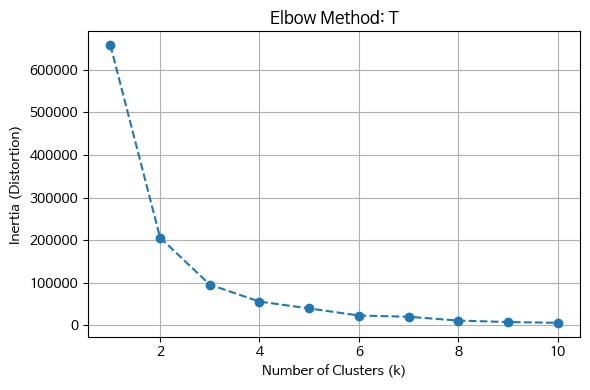

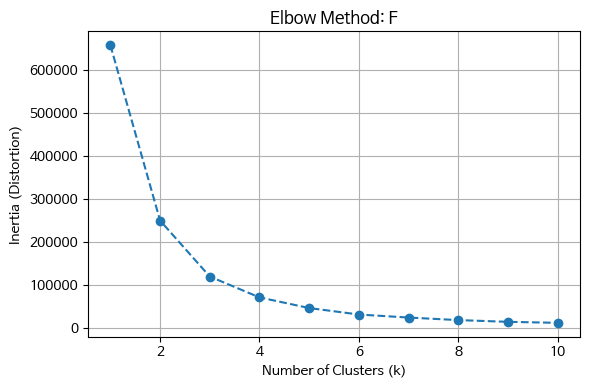

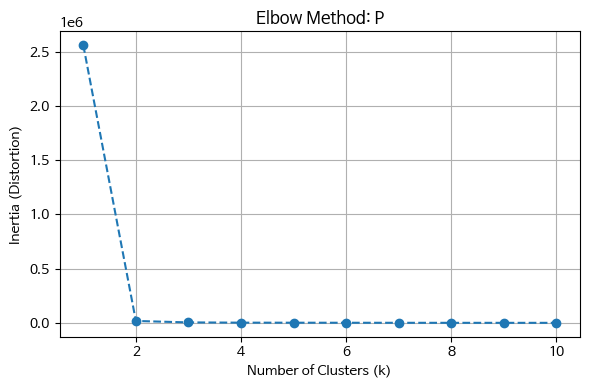

In [161]:
# Elbow Method를 통해 각 변수별 최적 k값을 시각적으로 판단하는 코드

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Elbow Method를 시각화하는 함수 정의
def plot_elbow_curve(df, col, max_k=10):
    distortions = []
    for k in range(1, max_k + 1):
        model = KMeans(n_clusters=k, init='k-means++', random_state=42)
        model.fit(df[[col]])
        distortions.append(model.inertia_)

    plt.figure(figsize=(6, 4))
    plt.plot(range(1, max_k + 1), distortions, marker='o', linestyle='--')
    plt.title(f'Elbow Method: {col}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Distortion)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# df_scaled에서 T, F, P 각각에 대해 Elbow Plot 그리기
for col in ['T', 'F', 'P']:
    plot_elbow_curve(df_scaled, col)


In [162]:
# Step 2: 변수별 KMeans 군집화 후 변동계수(CV) 계산 → 최소 CV 추출

from sklearn.cluster import KMeans

# 각 변수별로 적용할 클러스터 수 (이전에 elbow에서 판단한 값)
k_values = {
    'T': 4,  # total_using_days
    'F': 4,  # request_count
    'P': 2   # point_sum
}

# 각 변수에 대한 최소 CV 계산 함수
def calculate_min_cv(data, col, k):
    model = KMeans(n_clusters=k, random_state=42)
    data_copy = data[[col]].copy()
    data_copy['cluster'] = model.fit_predict(data[[col]])

    cv_list = []
    for i in range(k):
        cluster_vals = data_copy[data_copy['cluster'] == i][col]
        mean = cluster_vals.mean()
        std = cluster_vals.std()
        if mean != 0:
            cv = std / (mean + 1e-6)
            cv_list.append(cv)
    return min(cv_list)

# 각 변수에 대해 최소 CV 추출
cv_results = {col: calculate_min_cv(df_scaled, col, k) for col, k in k_values.items()}

cv_results


{'T': np.float64(-74.68487342464792),
 'F': np.float64(-0.3673451015358405),
 'P': np.float64(0.0792611291883891)}

In [163]:
# Step 3: 최소 CV 값을 기반으로 상대 가중치 w1~w3 계산 → 정규화된 W1~W3 산출

# 1. 총합 계산
total_cv = sum(cv_results.values())

# 2. 정규화된 가중치 계산
weight_results = {col: cv / total_cv for col, cv in cv_results.items()}

weight_results


{'T': np.float64(0.9961574948841622),
 'F': np.float64(0.0048997013628618346),
 'P': np.float64(-0.001057196247023938)}

In [164]:
# Step 4: 정규화된 가중치를 이용한 최종 PTF_SCORE 계산

# 가중치 할당
W_T = weight_results['T']
W_F = weight_results['F']
W_P = weight_results['P']

# PTF_SCORE 계산
df_scaled['PTF_SCORE'] = (
    df_scaled['T'] * W_T +
    df_scaled['F'] * W_F +
    df_scaled['P'] * W_P
)
df_scaled


,T,F,P,PTF_SCORE
0,-1.209585,-2.831505,0.0,-1.218811
1,-0.309933,-0.166586,0.0,-0.309558
2,-0.309933,-0.043417,0.0,-0.308954
3,0.879343,0.515521,0.0,0.878490
4,0.216330,0.116514,0.0,0.216070
...,...,...,...,...
657986,-1.209585,-2.831505,0.0,-1.218811
657987,-1.209585,0.164527,0.0,-1.204131
657988,-1.209585,-2.149398,0.0,-1.215469
657989,-1.209585,-1.467291,0.0,-1.212126


In [165]:
# 7. 분위 기반 등급화
df_scaled['PTF_grade_qcut'] = pd.qcut(df_scaled['PTF_SCORE'], 6, labels=[6, 5, 4, 3, 2, 1])

In [166]:
# 8. KMeans 기반 등급화
kmeans_model = KMeans(n_clusters=6, random_state=42)
df_scaled['PTF_grade_kmeans'] = kmeans_model.fit_predict(df_scaled[['PTF_SCORE']])

In [167]:
# 9. 등급별 통계 요약
qcut_summary = df_scaled.groupby('PTF_grade_qcut')[['PTF_SCORE', 'T', 'F', 'P']].mean().rename_axis('Grade (qcut)').round(4)
qcut_summary['Count'] = df_scaled['PTF_grade_qcut'].value_counts().sort_index()

kmeans_summary = df_scaled.groupby('PTF_grade_kmeans')[['PTF_SCORE', 'T', 'F', 'P']].mean().rename_axis('Grade (kmeans)').round(4)
kmeans_summary['Count'] = df_scaled['PTF_grade_kmeans'].value_counts().sort_index()

/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/4124434634.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  qcut_summary = df_scaled.groupby('PTF_grade_qcut')[['PTF_SCORE', 'T', 'F', 'P']].mean().rename_axis('Grade (qcut)').round(4)


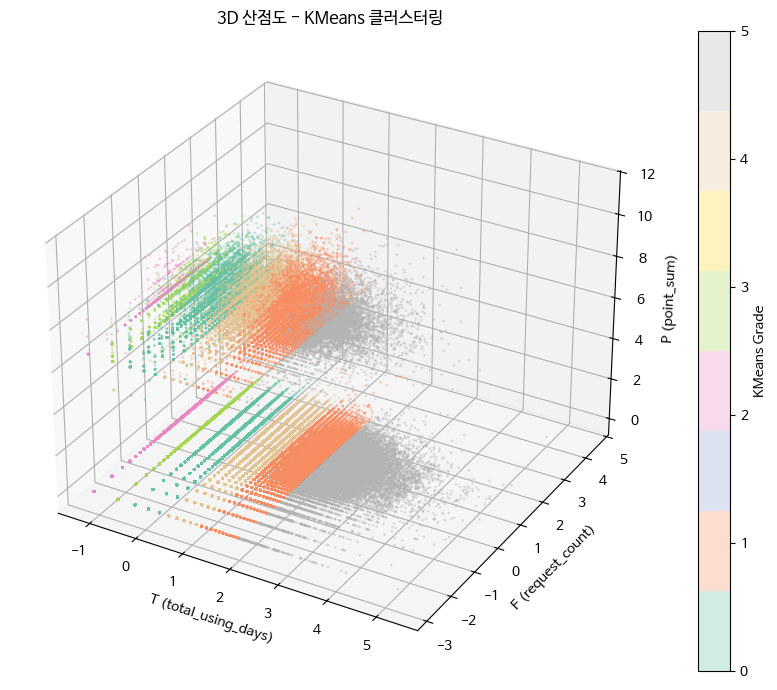

In [168]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_scaled['T'],
    df_scaled['F'],
    df_scaled['P'],
    c=df_scaled['PTF_grade_kmeans'],  # 클러스터에 따라 색상 지정
    cmap='Set2',
    alpha=0.3,
    s=1
)

ax.set_xlabel('T (total_using_days)')
ax.set_ylabel('F (request_count)')
ax.set_zlabel('P (point_sum)')
ax.set_title('3D 산점도 - KMeans 클러스터링')

plt.colorbar(scatter, label='KMeans Grade')
plt.tight_layout()
plt.show()

# 최적의 k 다시 찾기

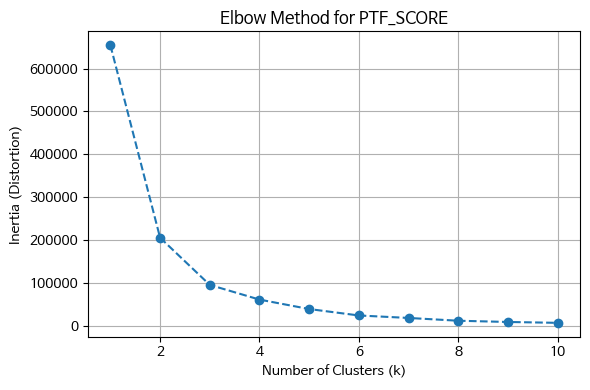

In [169]:
# Elbow Method를 사용해 df_scaled의 PTF_SCORE에 대한 최적의 k 값을 시각적으로 찾기

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Elbow plot 생성
def plot_elbow(data, col='PTF_SCORE', max_k=10):
    distortions = []
    for k in range(1, max_k + 1):
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(data[[col]])
        distortions.append(model.inertia_)

    plt.figure(figsize=(6, 4))
    plt.plot(range(1, max_k + 1), distortions, marker='o', linestyle='--')
    plt.title(f'Elbow Method for {col}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Distortion)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 실행
plot_elbow(df_scaled, col='PTF_SCORE', max_k=10)


In [170]:
# 사용자가 선택한 k=4로 KMeans 클러스터링 적용 + 분석 + 시각화

# 1. KMeans 클러스터링 (k=4)
kmeans_model_4 = KMeans(n_clusters=4, random_state=42)
df_scaled['PTF_cluster_k4'] = kmeans_model_4.fit_predict(df_scaled[['PTF_SCORE']])

# 2. 클러스터별 통계 요약
cluster_summary_k4 = df_scaled.groupby('PTF_cluster_k4')[['PTF_SCORE', 'T', 'F', 'P']].mean().round(4)
cluster_summary_k4['Count'] = df_scaled['PTF_cluster_k4'].value_counts().sort_index()

cluster_summary_k4

,PTF_SCORE,T,F,P,Count
PTF_cluster_k4,,,,,
0,0.3444,0.3452,0.2964,0.8277,213324
1,1.5872,1.5927,0.3689,1.1434,122165
2,-1.2087,-1.2096,-0.7508,0.0397,147053
3,-0.5133,-0.5149,0.0120,0.4614,175449


In [171]:
df_scaled['PTF_cluster_k4'].value_counts()

PTF_cluster_k4
0    213324
3    175449
2    147053
1    122165
Name: count, dtype: int64

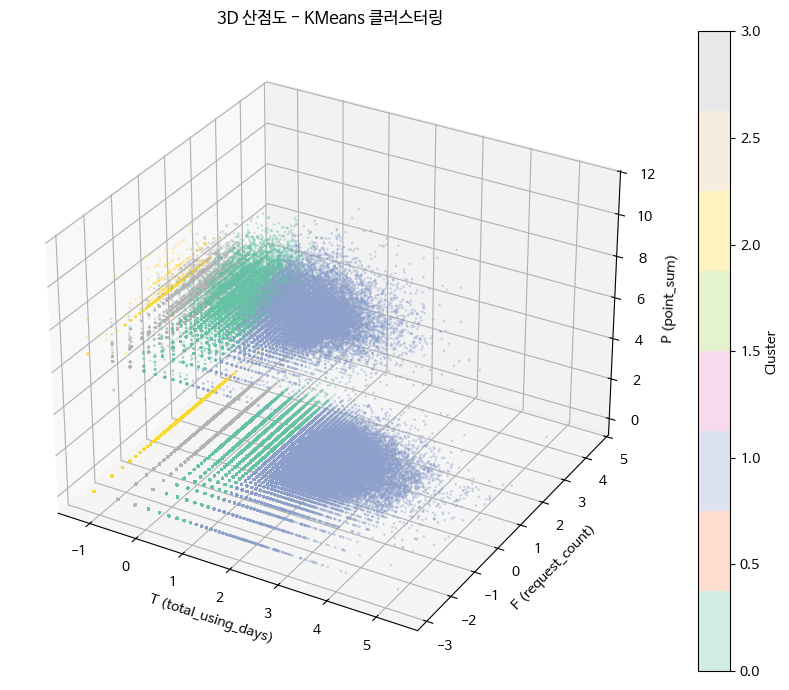

In [172]:

# 3. 3D 시각화
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_scaled['T'],
    df_scaled['F'],
    df_scaled['P'],
    c=df_scaled['PTF_cluster_k4'],
    cmap='Set2',
    alpha=0.3,
    s=1
)

ax.set_xlabel('T (total_using_days)')
ax.set_ylabel('F (request_count)')
ax.set_zlabel('P (point_sum)')
ax.set_title('3D 산점도 - KMeans 클러스터링')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()


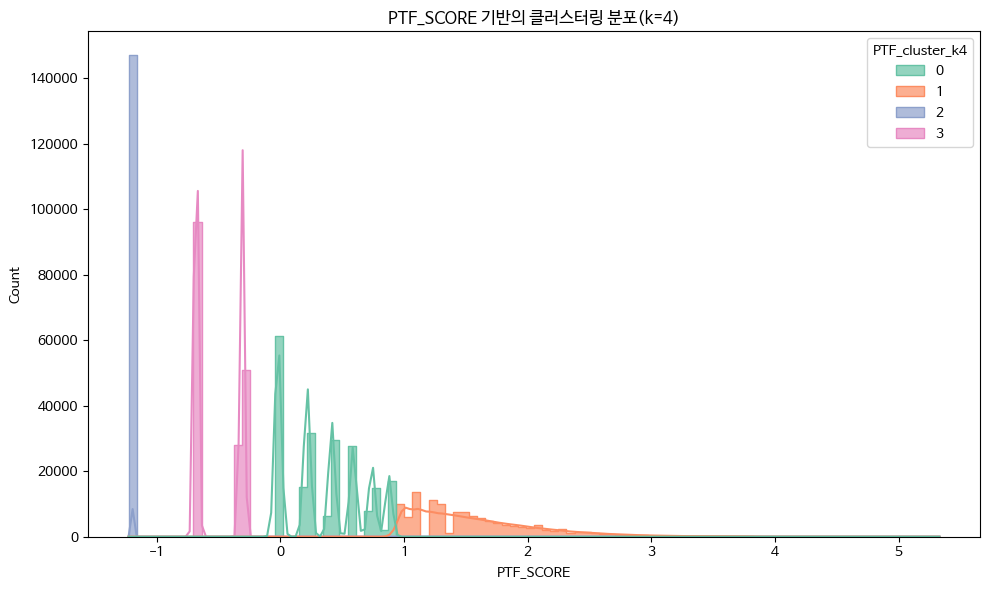

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

# PTF_SCORE 분포 시각화 (클러스터별 구분 포함)
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_scaled,
    x='PTF_SCORE',
    hue='PTF_cluster_k4',
    palette='Set2',
    bins=100,
    kde=True,
    alpha=0.7,
    element='step'
)
plt.title('PTF_SCORE 기반의 클러스터링 분포(k=4)')
plt.xlabel('PTF_SCORE')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 보정한 변동계수로 최종 클러스터링

In [174]:
df_merged_a = df_merged.copy()

In [175]:
# Step 1: 각 변수에 대해 적절한 로그 변환 + 스케일링 (DACON 방식 반영)

from sklearn.preprocessing import StandardScaler, RobustScaler
import numpy as np

# 1. 로그 변환
df_log = df_merged_a.copy()
for col in ['total_using_days', 'request_count', 'point_sum']:
    df_log[col] = np.log1p(df_log[col])

# 2. 변수별 스케일링 적용
scaler_t = StandardScaler()
scaler_f = StandardScaler()
scaler_p = RobustScaler()

df_scaled = pd.DataFrame({
    'T': scaler_t.fit_transform(df_log[['total_using_days']]).flatten(),
    'F': scaler_f.fit_transform(df_log[['request_count']]).flatten(),
    'P': scaler_p.fit_transform(df_log[['point_sum']]).flatten(),
})



df_scaled

,T,F,P
0,-1.209585,-2.831505,0.0
1,-0.309933,-0.166586,0.0
2,-0.309933,-0.043417,0.0
3,0.879343,0.515521,0.0
4,0.216330,0.116514,0.0
...,...,...,...
657986,-1.209585,-2.831505,0.0
657987,-1.209585,0.164527,0.0
657988,-1.209585,-2.149398,0.0
657989,-1.209585,-1.467291,0.0


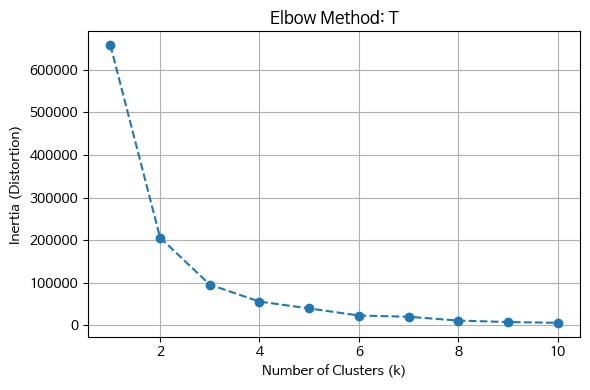

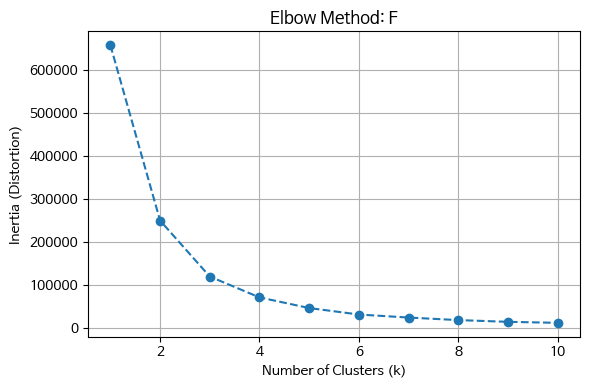

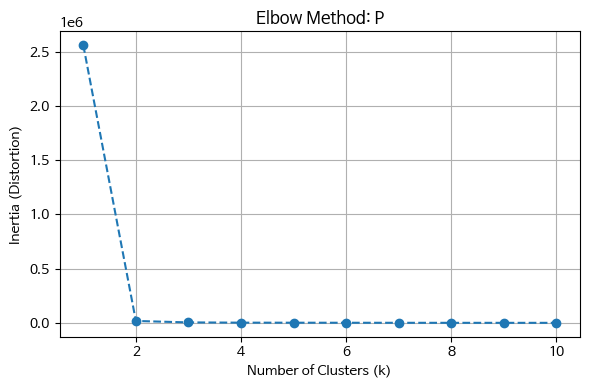

In [176]:
# Elbow Method를 통해 각 변수별 최적 k값을 시각적으로 판단하는 코드

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Elbow Method를 시각화하는 함수 정의
def plot_elbow_curve(df, col, max_k=10):
    distortions = []
    for k in range(1, max_k + 1):
        model = KMeans(n_clusters=k, init='k-means++', random_state=42)
        model.fit(df[[col]])
        distortions.append(model.inertia_)

    plt.figure(figsize=(6, 4))
    plt.plot(range(1, max_k + 1), distortions, marker='o', linestyle='--')
    plt.title(f'Elbow Method: {col}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Distortion)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# df_scaled에서 T, F, P 각각에 대해 Elbow Plot 그리기
for col in ['T', 'F', 'P']:
    plot_elbow_curve(df_scaled, col)


In [177]:
# 전체 흐름 재정리: 안전한 CV 계산 → 루트 보정 & 로그 역수 보정 → 정규화된 가중치 추출

from sklearn.cluster import KMeans
import numpy as np

# 1. 클러스터 수 설정
k_values = {
    'T': 4,  # total_using_days
    'F': 4,  # request_count
    'P': 2   # point_sum
}

# 2. 안전한 CV 계산 함수
def calculate_min_cv_safe(data, col, k):
    model = KMeans(n_clusters=k, random_state=42)
    data_copy = data[[col]].copy()
    data_copy['cluster'] = model.fit_predict(data[[col]])

    cv_list = []
    for i in range(k):
        cluster_vals = data_copy[data_copy['cluster'] == i][col]
        mean = cluster_vals.mean()
        std = cluster_vals.std()

        # 보호 로직
        if mean > 0:
            cv = std / mean
        elif mean < 0:
            cv = std / abs(mean)
        else:
            cv = np.nan

        if not np.isnan(cv) and np.isfinite(cv):
            cv_list.append(cv)

    return min(cv_list) if cv_list else np.nan

# 3. 각 변수별 최소 CV 계산
cv_results = {col: calculate_min_cv_safe(df_scaled, col, k) for col, k in k_values.items()}

# 4. 루트 보정 후 정규화
cv_sqrt = {k: np.sqrt(v) for k, v in cv_results.items() if not np.isnan(v)}
total_sqrt = sum(cv_sqrt.values())
weight_sqrt = {k: v / total_sqrt for k, v in cv_sqrt.items()}

# 5. 로그 역수 보정 후 정규화
cv_loginv = {k: 1 / np.log1p(v) for k, v in cv_results.items() if not np.isnan(v)}
total_loginv = sum(cv_loginv.values())
weight_loginv = {k: v / total_loginv for k, v in cv_loginv.items()}

(cv_results, weight_sqrt, weight_loginv)


({'T': np.float64(0.22896412449737874),
  'F': np.float64(0.1211950647328585),
  'P': np.float64(0.07926114064924214)},
 {'T': np.float64(0.4317961551177815),
  'F': np.float64(0.3141503287331749),
  'P': np.float64(0.25405351614904365)},
 {'T': np.float64(0.18164575402722496),
  'F': np.float64(0.3273758253295372),
  'P': np.float64(0.4909784206432378)})

In [178]:
# Step 3: 최소 CV 값을 기반으로 상대 가중치 w1~w3 계산 → 정규화된 W1~W3 산출

# 1. 총합 계산
total_cv = sum(weight_sqrt.values())

# 2. 정규화된 가중치 계산
weight_results = {col: cv / total_cv for col, cv in weight_sqrt.items()}

weight_results

{'T': np.float64(0.4317961551177815),
 'F': np.float64(0.3141503287331749),
 'P': np.float64(0.25405351614904365)}

In [179]:
# Step 4: 정규화된 가중치를 이용한 최종 PTF_SCORE 계산

# 가중치 할당
W_T = weight_results['T']
W_F = weight_results['F']
W_P = weight_results['P']

# PTF_SCORE 계산
df_scaled['PTF_SCORE'] = (
    df_scaled['T'] * W_T +
    df_scaled['F'] * W_F +
    df_scaled['P'] * W_P
)
df_scaled

,T,F,P,PTF_SCORE
0,-1.209585,-2.831505,0.0,-1.411813
1,-0.309933,-0.166586,0.0,-0.186161
2,-0.309933,-0.043417,0.0,-0.147467
3,0.879343,0.515521,0.0,0.541648
4,0.216330,0.116514,0.0,0.130014
...,...,...,...,...
657986,-1.209585,-2.831505,0.0,-1.411813
657987,-1.209585,0.164527,0.0,-0.470608
657988,-1.209585,-2.149398,0.0,-1.197528
657989,-1.209585,-1.467291,0.0,-0.983244


In [180]:
# 사용자가 선택한 k=4로 KMeans 클러스터링 적용 + 분석 + 시각화

# 1. KMeans 클러스터링 (k=4)
kmeans_model_4 = KMeans(n_clusters=4, random_state=42)
df_scaled['PTF_cluster_k4'] = kmeans_model_4.fit_predict(df_scaled[['PTF_SCORE']])

# 2. 클러스터별 통계 요약
cluster_summary_k4 = df_scaled.groupby('PTF_cluster_k4')[['PTF_SCORE', 'T', 'F', 'P']].mean().round(4)
cluster_summary_k4['Count'] = df_scaled['PTF_cluster_k4'].value_counts().sort_index()

cluster_summary_k4

,PTF_SCORE,T,F,P,Count
PTF_cluster_k4,,,,,
0,-0.8012,-1.0423,-1.1177,0.0000,160859
1,0.6988,1.0421,0.6020,0.2349,168785
2,-0.0310,-0.2129,0.1938,0.0003,272015
3,2.1614,0.8820,0.4520,6.4497,56332


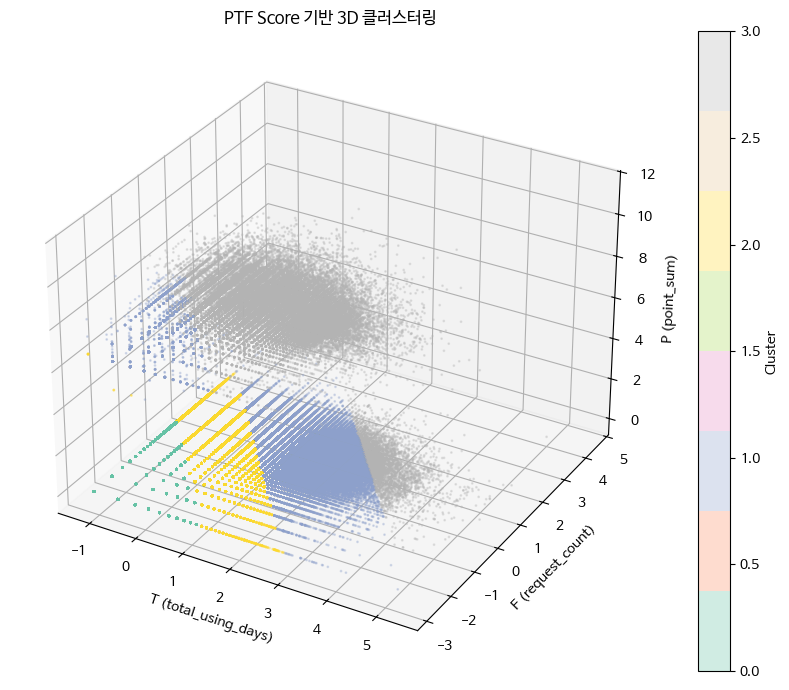

In [181]:

# 3. 3D 시각화
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_scaled['T'],
    df_scaled['F'],
    df_scaled['P'],
    c=df_scaled['PTF_cluster_k4'],
    cmap='Set2',
    alpha=0.3,
    s=1
)

ax.set_xlabel('T (total_using_days)')
ax.set_ylabel('F (request_count)')
ax.set_zlabel('P (point_sum)')
ax.set_title('PTF Score 기반 3D 클러스터링')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()


In [182]:
# 인덱스 기준으로 그대로 concat
df_merged_a = pd.concat([df_merged_a, df_scaled[['PTF_SCORE', 'PTF_cluster_k4']]], axis=1)
df_merged_a

,user_id,total_using_days,point_sum,request_count,PTF_SCORE,PTF_cluster_k4
0,855179,1,0.0,0.0,-1.411813,0
1,862517,3,0.0,14.0,-0.186161,2
2,862518,3,0.0,16.0,-0.147467,2
3,862519,9,0.0,29.0,0.541648,1
4,862520,5,0.0,19.0,0.130014,2
...,...,...,...,...,...,...
657986,1583729,1,0.0,0.0,-1.411813,0
657987,1583730,1,0.0,20.0,-0.470608,0
657988,1583731,1,0.0,1.0,-1.197528,0
657989,1583732,1,0.0,3.0,-0.983244,0


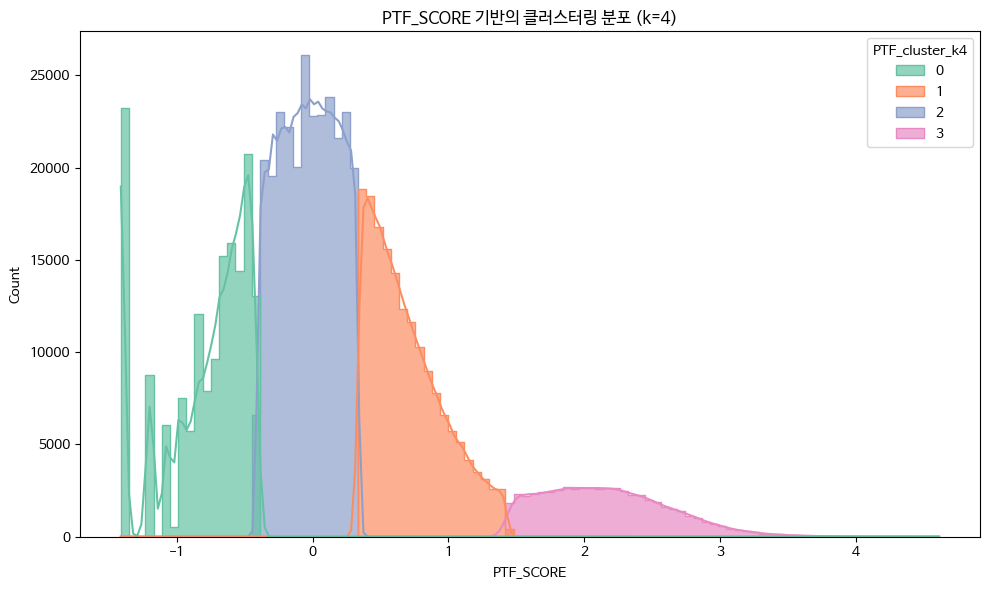

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

# PTF_SCORE 분포 시각화 (클러스터별 구분 포함)
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_merged_a,
    x='PTF_SCORE',
    hue='PTF_cluster_k4',
    palette='Set2',
    bins=100,
    kde=True,
    alpha=0.7,
    element='step'
)
plt.title('PTF_SCORE 기반의 클러스터링 분포 (k=4)')
plt.xlabel('PTF_SCORE')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# PCA

## 변수 생성

In [184]:
accounts_user.rename(columns = {'id' : 'user_id'}, inplace=True)

In [193]:
print(accounts_user.columns.tolist())

['user_id', 'is_superuser', 'is_staff', 'gender', 'point', 'friend_id_list', 'is_push_on', 'created_at', 'block_user_id_list', 'hide_user_id_list', 'ban_status', 'report_count', 'alarm_count', 'pending_chat', 'pending_votes', 'group_id']


In [194]:
use_columns = [
    'user_id',            # ← 'id' 대신
    'created_at',
    'friend_id_list',
    'block_user_id_list',
    'report_count',
    'pending_chat',
    'pending_votes'
]

accounts_user_filtered = accounts_user[use_columns]
accounts_user_filtered.head()  # 결과 확인

,user_id,created_at,friend_id_list,block_user_id_list,report_count,pending_chat,pending_votes
1,831962,2023-03-29 05:18:56.162368,"[833025, 832642, 982531, 879496, 838541, 83752...",[],253,5499,110
2,832151,2023-03-29 12:56:34.989468,"[838785, 982531, 882567, 879496, 838541, 83649...",[],0,0,47
3,832340,2023-03-29 12:56:35.020790,"[841345, 982531, 838785, 963714, 882567, 83252...",[],0,0,21
4,832520,2023-03-29 12:56:35.049311,"[874050, 849763, 874212, 844297, 838541, 84004...",[],0,0,15
5,832614,2023-03-29 12:56:35.064406,"[838541, 833041, 832151, 837806, 1437874, 1142...",[],0,0,14


In [195]:
# accounts_pointhistory
use_columns = ['user_id', 'created_at', 'delta_point']
accounts_pointhistory[use_columns]

,user_id,created_at,delta_point
0,849436,2023-04-28 12:27:49,9
1,849436,2023-04-28 12:28:02,9
2,849436,2023-04-28 12:28:09,5
3,849436,2023-04-28 12:28:16,13
4,849436,2023-04-28 12:28:26,5
...,...,...,...
2338913,855509,2024-05-08 01:35:02,14
2338914,855525,2024-05-08 01:36:00,11
2338915,855526,2024-05-08 01:36:00,11
2338916,855525,2024-05-08 01:36:18,12


In [196]:
# accounts_paymenthistory
use_columns = ['user_id', 'created_at', 'productId']
accounts_paymenthistory[use_columns]

,user_id,created_at,productId
0,1211127,2023-05-13 21:28:34,777
1,1151343,2023-05-13 21:29:39,777
2,1002147,2023-05-13 21:31:33,777
3,1095040,2023-05-13 21:31:39,777
4,1164081,2023-05-13 21:34:32,777
...,...,...,...
95133,984854,2024-05-06 13:24:35,777
95134,1086654,2024-05-06 14:51:27,777
95136,871740,2024-05-06 16:06:30,1000
95137,1166361,2024-05-08 06:57:23,1000


In [198]:
print(accounts_friendrequest.columns.tolist())

['status', 'created_at', 'updated_at', 'receive_user_id', 'user_id']


In [200]:
accounts_friendrequest = accounts_friendrequest.rename(columns={'user_id': 'send_user_id'})

In [201]:
accounts_friendrequest['send_user_id']

0            837521
1            837521
2            837521
3            837521
4            837521
             ...   
17147170    1583731
17147171    1583673
17147172    1575671
17147173    1392729
17147174    1392729
Name: send_user_id, Length: 17147112, dtype: int64

In [202]:
accounts_user.rename(columns = {'id' : 'user_id'}, inplace=True)

In [203]:
accounts_blockrecord_id = accounts_blockrecord[accounts_blockrecord['created_at'] < "2023-05-01"]['user_id'].unique()
accounts_friendrequest_id = accounts_friendrequest[accounts_friendrequest['created_at'] < "2023-05-01"]['send_user_id'].unique()
accounts_paymenthistory_id = accounts_paymenthistory[accounts_paymenthistory['created_at'] < "2023-05-01"]['user_id'].unique()
accounts_pointhistory_id = accounts_pointhistory[accounts_pointhistory['created_at'] < "2023-05-01"]['user_id'].unique()
accounts_timelinereport_id = accounts_timelinereport[accounts_timelinereport['created_at'] < "2023-05-01"]['user_id'].unique()
accounts_userquestionrecord_id = accounts_userquestionrecord[accounts_userquestionrecord['created_at'] < "2023-05-01"]['user_id'].unique()
polls_questionreport_id = polls_questionreport[polls_questionreport['created_at'] < "2023-05-01"]['user_id'].unique()
polls_questionset_id = polls_questionset[polls_questionset['created_at'] < "2023-05-01"]['user_id'].unique()
polls_usercandidate_id = polls_usercandidate[polls_usercandidate['created_at'] < "2023-05-01"]['user_id'].unique()

In [204]:
# 5월 이전(4월 30일 이하) 데이터가 있는 user_id 찾기
accounts_blockrecord = accounts_blockrecord[~accounts_blockrecord['user_id'].isin(accounts_blockrecord_id)]
accounts_friendrequest = accounts_friendrequest[~accounts_friendrequest['send_user_id'].isin(accounts_friendrequest_id)]
accounts_paymenthistory = accounts_paymenthistory[~accounts_paymenthistory['user_id'].isin(accounts_paymenthistory_id)]
accounts_pointhistory = accounts_pointhistory[~accounts_pointhistory['user_id'].isin(accounts_pointhistory_id)]
accounts_timelinereport = accounts_timelinereport[~accounts_timelinereport['user_id'].isin(accounts_timelinereport_id)]
accounts_userquestionrecord = accounts_userquestionrecord[~accounts_userquestionrecord['user_id'].isin(accounts_userquestionrecord_id)]
polls_questionreport = polls_questionreport[~polls_questionreport['user_id'].isin(polls_questionreport_id)]
polls_questionset = polls_questionset[~polls_questionset['user_id'].isin(polls_questionset_id)]
polls_usercandidate = polls_usercandidate[~polls_usercandidate['user_id'].isin(polls_usercandidate_id)]

In [205]:
friendrequest = accounts_friendrequest.copy()
paymenthistory = accounts_paymenthistory.copy()
user = accounts_user.copy()
userquestionrecord = accounts_userquestionrecord.copy()
questionset = polls_questionset.copy()

In [206]:
# 5월 이전(4월 30일 이하) 데이터가 있는 user_id 찾기
questionset_user_id = questionset[questionset['created_at'] < "2023-05-01"]['user_id'].unique()
userquestionrecord_user_id = userquestionrecord[userquestionrecord['created_at'] < "2023-05-01"]['user_id'].unique()
paymenthistory_user_id = paymenthistory[paymenthistory['created_at'] < "2023-05-01"]['user_id'].unique()
user_user_id = user[user['created_at'] < "2023-05-01"]['user_id'].unique()
friendrequest_user_id = friendrequest[friendrequest['created_at'] < "2023-05-01"]['send_user_id'].unique()

questionset = questionset[~questionset['user_id'].isin(questionset_user_id)]
userquestionrecord = userquestionrecord[~userquestionrecord['user_id'].isin(userquestionrecord_user_id)]
paymenthistory = paymenthistory[~paymenthistory['user_id'].isin(paymenthistory_user_id)]
user = user[~user['user_id'].isin(user_user_id)]
friendrequest = friendrequest[~friendrequest['send_user_id'].isin(friendrequest_user_id)]

In [207]:
import ast

questionset["question_piece_id_list"] = questionset["question_piece_id_list"].apply(ast.literal_eval)
questionset = questionset.explode('question_piece_id_list')
questionset.rename(columns = {"question_piece_id_list" : "question_piece_id"}, inplace = True)
questionset = questionset.reset_index(drop=True)
questionset

,id,question_piece_id,opening_time,status,created_at,user_id
0,194016,1940448,2023-05-01 03:45:53,F,2023-05-01 03:45:53,863069
1,194016,1940449,2023-05-01 03:45:53,F,2023-05-01 03:45:53,863069
2,194016,1940450,2023-05-01 03:45:53,F,2023-05-01 03:45:53,863069
3,194016,1940451,2023-05-01 03:45:53,F,2023-05-01 03:45:53,863069
4,194016,1940452,2023-05-01 03:45:53,F,2023-05-01 03:45:53,863069
...,...,...,...,...,...,...
1457445,20838446,208385226,2024-05-07 12:12:30,C,2024-05-07 11:32:30,945560
1457446,20838446,208385227,2024-05-07 12:12:30,C,2024-05-07 11:32:30,945560
1457447,20838446,208385228,2024-05-07 12:12:30,C,2024-05-07 11:32:30,945560
1457448,20838446,208385229,2024-05-07 12:12:30,C,2024-05-07 11:32:30,945560


In [208]:
questionset.isna().sum()

id                   0
question_piece_id    0
opening_time         0
status               0
created_at           0
user_id              0
dtype: int64

In [209]:
total_question = pd.DataFrame(questionset.groupby('user_id')['question_piece_id'].count()).sort_values('question_piece_id', ascending=False)
total_question = total_question.reset_index(drop=False)
total_question

,user_id,question_piece_id
0,952220,3700
1,1184703,2150
2,1162477,2030
3,1213990,2020
4,877382,1820
...,...,...
4611,1028993,10
4612,1528224,10
4613,1221454,10
4614,874538,10


In [210]:
total_question.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4616 entries, 0 to 4615
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   user_id            4616 non-null   int64
 1   question_piece_id  4616 non-null   int64
dtypes: int64(2)
memory usage: 72.3 KB


In [211]:
total_created = pd.DataFrame(userquestionrecord.groupby('user_id')['created_at'].count())
total_created = total_created.reset_index(drop=False)
total_created

,user_id,created_at
0,838466,131
1,840293,170
2,840473,244
3,840474,41
4,840512,141
...,...,...
4506,1577440,23
4507,1578095,33
4508,1579418,49
4509,1580578,2


In [212]:
total_votes = pd.merge(total_created, total_question, on='user_id', how='outer')
total_votes.columns = ['user_id', 'create_times', 'join_times']
total_votes = total_votes.fillna(0)

In [213]:
total_votes['total_votes_count'] = total_votes['create_times'] + total_votes['join_times']
total_votes

,user_id,create_times,join_times,total_votes_count
0,838466,131.0,220.0,351.0
1,840293,170.0,200.0,370.0
2,840473,244.0,390.0,634.0
3,840474,41.0,140.0,181.0
4,840512,141.0,210.0,351.0
...,...,...,...,...
4624,1580629,0.0,10.0,10.0
4625,1581920,0.0,10.0,10.0
4626,1582145,0.0,10.0,10.0
4627,1582765,0.0,10.0,10.0


In [214]:
total_votes[total_votes['create_times'] == 0.0]

,user_id,create_times,join_times,total_votes_count
163,872546,0.0,10.0,10.0
169,872930,0.0,10.0,10.0
293,874538,0.0,10.0,10.0
315,874724,0.0,20.0,20.0
355,875234,0.0,10.0,10.0
...,...,...,...,...
4622,1579659,0.0,10.0,10.0
4624,1580629,0.0,10.0,10.0
4625,1581920,0.0,10.0,10.0
4626,1582145,0.0,10.0,10.0


In [215]:
total_votes['total_votes_count'].sort_values()

20         1.0
18         1.0
40         5.0
23         7.0
1920      10.0
         ...  
2568    3398.0
2729    3405.0
465     3488.0
2969    3715.0
1522    5227.0
Name: total_votes_count, Length: 4629, dtype: float64

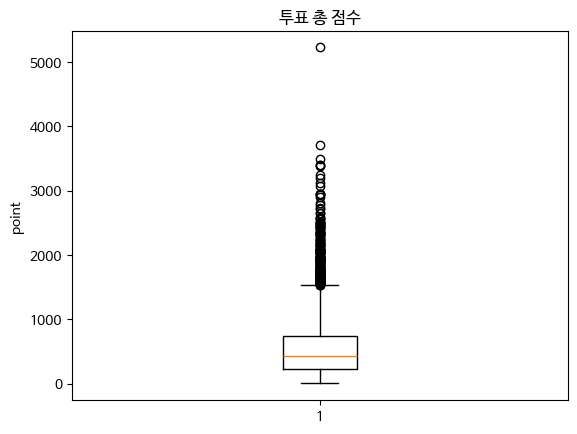

In [216]:
# box plot 
plt.boxplot(total_votes['total_votes_count'])
plt.title('투표 총 점수')
plt.ylabel('point')
plt.show()

In [217]:
total_votes[total_votes['total_votes_count'] > 4000]

,user_id,create_times,join_times,total_votes_count
1522,952220,1527.0,3700.0,5227.0


- 총 점수가 4000 이상인 이상치 제거

In [218]:
total_votes.drop(['create_times', 'join_times'], axis=1, inplace=True)
total_votes.tail()

,user_id,total_votes_count
4624,1580629,10.0
4625,1581920,10.0
4626,1582145,10.0
4627,1582765,10.0
4628,1583358,22.0


In [219]:
total_votes = total_votes[total_votes['total_votes_count'] <= 4000]

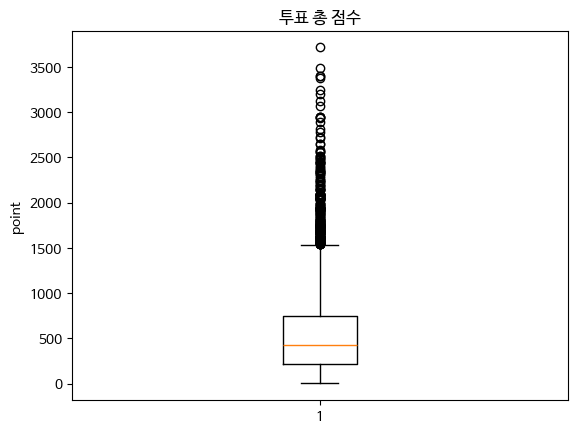

In [220]:
# box plot 
plt.boxplot(total_votes['total_votes_count'])
plt.title('투표 총 점수')
plt.ylabel('point')
plt.show()

- 상호 투표수

In [221]:
total_votes.shape

(4628, 2)

## 구매 포인트 수

In [226]:
friendrequest = accounts_friendrequest.copy()
paymenthistory = accounts_paymenthistory.copy()
user = accounts_user.copy()
userquestionrecord = accounts_userquestionrecord.copy()
questionset = polls_questionset.copy()

In [227]:
# 5월 이전(4월 30일 이하) 데이터가 있는 user_id 찾기
questionset_user_id = questionset[questionset['created_at'] < "2023-05-01"]['user_id'].unique()
userquestionrecord_user_id = userquestionrecord[userquestionrecord['created_at'] < "2023-05-01"]['user_id'].unique()
paymenthistory_user_id = paymenthistory[paymenthistory['created_at'] < "2023-05-01"]['user_id'].unique()
user_user_id = user[user['created_at'] < "2023-05-01"]['user_id'].unique()
friendrequest_user_id = friendrequest[friendrequest['created_at'] < "2023-05-01"]['send_user_id'].unique()

questionset = questionset[~questionset['user_id'].isin(questionset_user_id)]
userquestionrecord = userquestionrecord[~userquestionrecord['user_id'].isin(userquestionrecord_user_id)]
paymenthistory = paymenthistory[~paymenthistory['user_id'].isin(paymenthistory_user_id)]
user = user[~user['user_id'].isin(user_user_id)]
friendrequest = friendrequest[~friendrequest['send_user_id'].isin(friendrequest_user_id)]

In [233]:
paymenthistory

,productId,phone_type,created_at,user_id
0,777,A,2023-05-13 21:28:34,1211127
1,777,A,2023-05-13 21:29:39,1151343
2,777,A,2023-05-13 21:31:33,1002147
3,777,A,2023-05-13 21:31:39,1095040
4,777,A,2023-05-13 21:34:32,1164081
...,...,...,...,...
95133,777,I,2024-05-06 13:24:35,984854
95134,777,I,2024-05-06 14:51:27,1086654
95136,1000,I,2024-05-06 16:06:30,871740
95137,1000,I,2024-05-08 06:57:23,1166361


In [235]:
payment = paymenthistory[['user_id', 'productId']]
payment.tail()

,user_id,productId
95133,984854,777
95134,1086654,777
95136,871740,1000
95137,1166361,1000
95138,1163480,1000


In [236]:
payment = paymenthistory[['user_id', 'productId']]
payment.tail()

,user_id,productId
95133,984854,777
95134,1086654,777
95136,871740,1000
95137,1166361,1000
95138,1163480,1000


In [238]:
print(payment['productId'].dtype)
print(payment['productId'].head())

int64
0    777
1    777
2    777
3    777
4    777
Name: productId, dtype: int64


In [240]:
payment['product'] = payment['productId']
payment

/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/3666184208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payment['product'] = payment['productId']


,user_id,productId,product
0,1211127,777,777
1,1151343,777,777
2,1002147,777,777
3,1095040,777,777
4,1164081,777,777
...,...,...,...
95133,984854,777,777
95134,1086654,777,777
95136,871740,1000,1000
95137,1166361,1000,1000


In [241]:
payment['product'] = payment['product'].astype(int)

/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/3020101056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payment['product'] = payment['product'].astype(int)


In [242]:
new_payment = pd.DataFrame(payment.groupby('user_id')['product'].sum())
new_payment.columns = ['purchase_count']
new_payment = new_payment.reset_index(drop=False)
new_payment.tail()

,user_id,purchase_count
59187,1583408,2331
59188,1583445,200
59189,1583450,777
59190,1583454,1554
59191,1583632,777


## 친구 수

In [243]:
friend = user[['user_id', 'friend_id_list']]
friend.tail()

,user_id,friend_id_list
677080,1583729,[]
677081,1583730,"[1109507, 1110921, 1111072, 1110054, 1108393, ..."
677082,1583731,"[1583732, 1583673]"
677083,1583732,"[1583673, 1583730, 1583731]"
677084,1583733,[]


In [244]:
print(friend["friend_id_list"].dtype)

object


In [245]:
print(friend["friend_id_list"].apply(type).unique())

[<class 'str'>]


In [246]:
import ast

friend["friend_id_list"] = friend["friend_id_list"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
friend["friend_count"] = friend["friend_id_list"].apply(len)
friend

/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/1010312259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  friend["friend_id_list"] = friend["friend_id_list"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/1010312259.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  friend["friend_count"] = friend["friend_id_list"].apply(len)


,user_id,friend_id_list,friend_count
13302,855179,"[849767, 850569, 857770, 856249, 850108, 869470]",6
19094,862517,"[880775, 838285, 868495, 875156, 838421, 83842...",58
19095,862518,"[857473, 846981, 860934, 858247, 859913, 86901...",41
19096,862519,"[1215494, 1150344, 1520776, 1160844, 1090445, ...",74
19097,862520,"[874368, 856706, 1407234, 982788, 1145859, 100...",46
...,...,...,...
677080,1583729,[],0
677081,1583730,"[1109507, 1110921, 1111072, 1110054, 1108393, ...",21
677082,1583731,"[1583732, 1583673]",2
677083,1583732,"[1583673, 1583730, 1583731]",3


In [247]:
friend.drop('friend_id_list', axis=1, inplace=True)
friend

/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/4197468775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  friend.drop('friend_id_list', axis=1, inplace=True)


,user_id,friend_count
13302,855179,6
19094,862517,58
19095,862518,41
19096,862519,74
19097,862520,46
...,...,...
677080,1583729,0
677081,1583730,21
677082,1583731,2
677083,1583732,3


## 차단된 사용자 수

In [248]:
block = user[['user_id','block_user_id_list']]
block.tail()

,user_id,block_user_id_list
677080,1583729,[]
677081,1583730,[]
677082,1583731,[]
677083,1583732,[]
677084,1583733,[]


In [249]:
import ast

block["block_user_id_list"] = block["block_user_id_list"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
block["block_count"] = block["block_user_id_list"].apply(len)
block

/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/3835325154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block["block_user_id_list"] = block["block_user_id_list"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/3835325154.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block["block_count"] = block["block_user_id_list"].apply(len)


,user_id,block_user_id_list,block_count
13302,855179,[],0
19094,862517,[],0
19095,862518,[],0
19096,862519,[],0
19097,862520,[],0
...,...,...,...
677080,1583729,[],0
677081,1583730,[],0
677082,1583731,[],0
677083,1583732,[],0


In [250]:
block[block['block_count'] != 0]

,user_id,block_user_id_list,block_count
19132,862562,[1314665],1
19168,862600,[1059160],1
19244,862683,[860384],1
19312,862758,[865585],1
19320,862767,[937402],1
...,...,...,...
673123,1579568,[1088412],1
673319,1579809,"[951502, 948978, 958151, 1004543]",4
673530,1580066,[962736],1
673731,1580317,[1070407],1


In [251]:
block.drop('block_user_id_list', axis = 1, inplace=True)

/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/3622528972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block.drop('block_user_id_list', axis = 1, inplace=True)


## 신고 받은 횟수

In [252]:
user['report_count'].nunique()

35

In [253]:
user[user['report_count'] != 0]

,user_id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
19121,862551,0,0,F,455,"[855043, 851588, 860291, 862343, 842507, 85774...",1,2023-05-01 00:23:53.664551,[],[],N,1,1,0,118,5683.0
19127,862557,0,0,F,5564,"[862343, 868620, 869645, 864404, 856733, 85942...",1,2023-05-01 00:25:02.379092,[],"[854718, 862696, 858478, 862693, 858538, 86032...",N,1,0,0,8,5683.0
19168,862600,0,0,M,164,"[858752, 858881, 880640, 874627, 860421, 87783...",1,2023-05-01 00:44:40.381447,[1059160],[871946],N,2,0,0,173,2836.0
19186,862619,0,0,F,1462,"[872199, 929288, 845577, 869642, 868620, 86926...",1,2023-05-01 00:54:48.655507,[],[],N,1,0,0,1,2323.0
19343,862795,0,0,F,7177,"[872962, 1146882, 862726, 1413638, 862730, 891...",0,2023-05-01 02:14:39.941625,[],[],N,1,0,2,3,7431.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672762,1579157,0,0,M,756,"[1251335, 1006343, 1014794, 1164302, 958998, 1...",1,2023-07-20 12:04:33.754923,[],[],N,1,0,0,1,23645.0
672800,1579196,0,0,F,448,"[983424, 974469, 1393798, 983049, 1556365, 108...",0,2023-07-21 02:49:23.799762,[],[],N,2,2,0,0,27252.0
673065,1579499,0,0,F,930,[1579532],1,2023-07-27 09:29:11.273395,[],[],N,1,0,0,0,65233.0
673243,1579720,0,0,M,478,"[1131072, 1209378, 1131075, 1313476, 1206631, ...",1,2023-08-04 11:15:21.303561,[],[],N,1,0,0,0,46239.0


In [254]:
report = user[['user_id','report_count']]
report.head()


,user_id,report_count
13302,855179,0
19094,862517,0
19095,862518,0
19096,862519,0
19097,862520,0


## 대기 중인 채팅 요청 수

In [255]:
user['pending_chat'].nunique()

47

In [256]:
user[user['pending_chat'] !=0]

,user_id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
19103,862529,0,0,F,7341,"[872962, 862726, 862730, 868877, 873491, 88630...",1,2023-05-01 00:06:09.994563,[],[],N,0,1,1,8,7309.0
19107,862533,0,0,F,8092,"[858120, 868872, 844299, 1459213, 857101, 8473...",1,2023-05-01 00:10:44.935679,[],[890769],N,0,2,3,89,6770.0
19110,862536,0,0,F,1932,"[861953, 859910, 859400, 861195, 1117197, 8601...",1,2023-05-01 00:12:15.176333,[],[],N,0,1,1,42,4354.0
19169,862601,0,0,M,102,"[858881, 860421, 862600, 867337, 877832, 85210...",1,2023-05-01 00:45:25.586659,[],[],N,0,2,1,87,4471.0
19202,862635,0,0,F,1147,"[883720, 894984, 861708, 867358, 867874, 86327...",1,2023-05-01 01:05:06.695952,[],[867994],N,0,1,1,488,7250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676821,1583469,0,0,F,300,"[1104707, 1125256, 1112809, 1104522, 1161001, ...",1,2024-03-29 10:48:10.422124,[],[],N,0,0,1,0,41651.0
676908,1583556,0,0,F,300,"[1051270, 961805, 1392019, 1171606, 1062041, 1...",1,2024-04-10 13:08:37.248938,[],[],W,0,0,7,0,17103.0
676964,1583612,0,0,F,300,[1582869],1,2024-04-19 15:16:07.876679,[1582869],[],N,0,0,2,0,84134.0
677022,1583671,0,0,F,300,[],0,2024-04-28 16:04:07.534229,[],[],N,0,0,2,0,16517.0


In [257]:
34257 / len(user) * 100

5.206302213860068

In [258]:
chat = user[['user_id', 'pending_chat']]
chat.head()


,user_id,pending_chat
13302,855179,0
19094,862517,0
19095,862518,0
19096,862519,0
19097,862520,0


## 대기 중인 투표 수

In [259]:
user['pending_votes'].nunique()

1182

In [260]:
user[user['pending_votes'] != 0].tail()

,user_id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
676985,1583634,0,0,F,519,"[1458690, 1504137, 1432715, 847244, 1583632, 1...",1,2024-04-23 03:34:57.094026,[],[],N,0,0,0,3,71801.0
676986,1583635,0,0,F,626,"[1382528, 1184385, 847626, 1236621, 1533837, 1...",1,2024-04-23 03:48:30.194472,[],[],N,0,1,0,26,27317.0
677039,1583688,0,0,M,366,"[1583504, 1583294, 1583503, 1583689, 1583690]",1,2024-05-01 09:20:42.633659,[],[],N,0,2,0,8,41597.0
677040,1583689,0,0,M,362,"[1583504, 1583688, 1583294, 1583503, 1583690]",1,2024-05-01 09:25:42.806731,[],[],N,0,1,0,7,41597.0
677041,1583690,0,0,M,350,"[1583688, 1583689, 1583503, 1583504, 1288117, ...",0,2024-05-01 10:53:08.526498,[],[],N,0,0,0,6,41597.0


In [261]:
pending_vote = user[['user_id','pending_votes']]
pending_vote.rename(columns= {'pending_votes' : 'pending_votes_count'}, inplace=True)
pending_vote

/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/3689304159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pending_vote.rename(columns= {'pending_votes' : 'pending_votes_count'}, inplace=True)


,user_id,pending_votes_count
13302,855179,23
19094,862517,19
19095,862518,61
19096,862519,180
19097,862520,190
...,...,...
677080,1583729,0
677081,1583730,0
677082,1583731,0
677083,1583732,0


## 친구 요청 보낸 횟수

In [262]:
friend_request = pd.DataFrame(friendrequest.groupby('send_user_id')['created_at'].count())
friend_request = friend_request.reset_index(drop=False)
friend_request.rename(columns= {'send_user_id' : 'user_id', 'created_at' : 'friend_request_count'}, inplace=True)
friend_request

,user_id,friend_request_count
0,831962,1
1,833024,2
2,833154,21
3,833294,23
4,833303,7
...,...,...
632125,1583726,50
632126,1583728,5
632127,1583730,20
632128,1583731,1


## 데이터 합치기

In [263]:
clustering_df = pd.merge(total_votes, new_payment, how='outer', on = 'user_id')
clustering_df = pd.merge(clustering_df, friend, how='outer', on = 'user_id')
clustering_df = pd.merge(clustering_df, pending_vote, how='outer', on = 'user_id')
clustering_df = pd.merge(clustering_df, friend_request, how='outer', on = 'user_id')
clustering_df = pd.merge(clustering_df, block, how='outer', on = 'user_id')
clustering_df = pd.merge(clustering_df, report, how='outer', on = 'user_id')
clustering_df = pd.merge(clustering_df, chat, how='outer', on = 'user_id')
clustering_df = clustering_df.fillna(0)
clustering_df.tail()


,user_id,total_votes_count,purchase_count,friend_count,pending_votes_count,friend_request_count,block_count,report_count,pending_chat
660119,1583729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
660120,1583730,0.0,0.0,21.0,0.0,20.0,0.0,0.0,0.0
660121,1583731,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0
660122,1583732,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0
660123,1583733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 공통

### 상관관계 확인

In [264]:
corr_matrix = clustering_df.corr()
corr_matrix

,user_id,total_votes_count,purchase_count,friend_count,pending_votes_count,friend_request_count,block_count,report_count,pending_chat
user_id,1.000000,-0.028311,0.030844,-0.222010,-0.200412,0.011856,-0.010163,-0.023461,0.007450
total_votes_count,-0.028311,1.000000,0.004677,0.024067,0.005827,0.014830,0.002652,0.006886,0.000420
purchase_count,0.030844,0.004677,1.000000,0.056959,-0.015407,0.042193,0.014045,0.021595,0.002788
friend_count,-0.222010,0.024067,0.056959,1.000000,0.400875,0.763918,0.018299,0.061711,0.012543
pending_votes_count,-0.200412,0.005827,-0.015407,0.400875,1.000000,0.132302,-0.000497,0.017362,0.006828
friend_request_count,0.011856,0.014830,0.042193,0.763918,0.132302,1.000000,0.013487,0.044849,0.011249
block_count,-0.010163,0.002652,0.014045,0.018299,-0.000497,0.013487,1.000000,0.006034,0.001364
report_count,-0.023461,0.006886,0.021595,0.061711,0.017362,0.044849,0.006034,1.000000,0.225076
pending_chat,0.007450,0.000420,0.002788,0.012543,0.006828,0.011249,0.001364,0.225076,1.000000


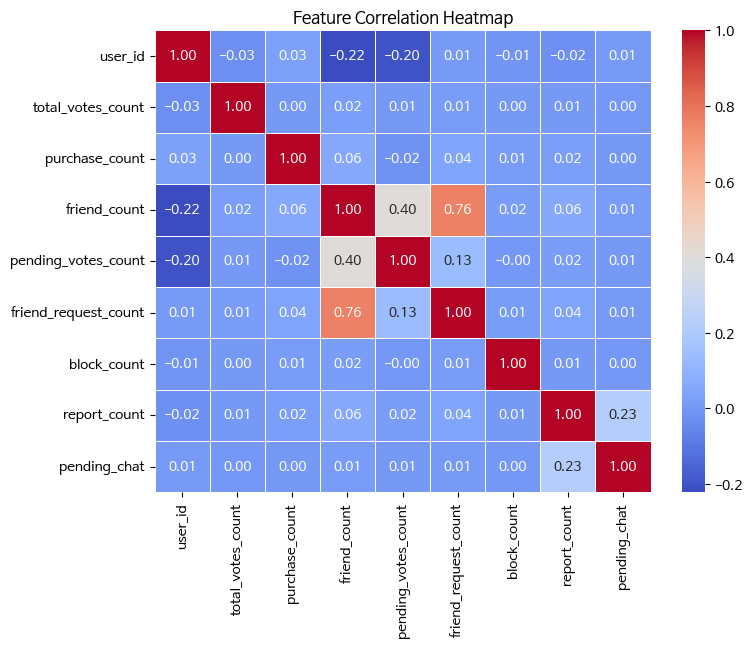

In [265]:
plt.figure(figsize=(8, 6))  # 그래프 크기 조절
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [266]:
cluster_df = clustering_df.copy()

In [268]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = cluster_df.drop(columns=['user_id'])

# 상수항 추가 (절편을 포함해야 정확한 VIF 계산 가능)
X['Intercept'] = 1  

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
print(vif_data)

                Feature       VIF
0     total_votes_count  1.000689
1        purchase_count  1.005725
2          friend_count  3.093830
3   pending_votes_count  1.307221
4  friend_request_count  2.629819
5           block_count  1.000605
6          report_count  1.057742
7          pending_chat  1.053410
8             Intercept  3.810349


### 변수별 왜도 확인

In [269]:
from scipy.stats import skew

# 숫자형 컬럼만 선택
numeric_cols = cluster_df.select_dtypes(include=['number']).columns

# 각 컬럼별 왜도 계산
skewness = cluster_df[numeric_cols].apply(skew, nan_policy='omit')

# 결과 출력
print(skewness)

user_id                   0.010164
total_votes_count        22.765030
purchase_count           22.192149
friend_count              2.030613
pending_votes_count       2.439351
friend_request_count      6.154399
block_count             205.394584
report_count             52.792177
pending_chat            721.437816
dtype: float64


- 모두 로그 변환 진행

### 로그 변환

In [270]:
print(cluster_df[['block_count', 'report_count', 'pending_chat']].describe())

         block_count   report_count   pending_chat
count  660124.000000  660124.000000  660124.000000
mean        0.028492       0.036623       0.076249
std         0.451518       0.375982       2.309750
min         0.000000       0.000000      -1.000000
25%         0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000
75%         0.000000       0.000000       0.000000
max       178.000000      71.000000    1801.000000


In [271]:
# 로그 변환 전 값이 음수인 것이 있다. -> 1 이상으로 만들어주기
cluster_df['pending_chat'] = cluster_df['pending_chat'] - cluster_df['pending_chat'].min()

In [272]:
# 0이 포함된 컬럼은 log(0)이 불가능하므로 1을 더해줌
non_user_df = cluster_df.drop(['user_id'], axis=1)
non_user_df = np.log1p(non_user_df)

cluster_df = pd.concat([cluster_df['user_id'], non_user_df], axis=1)
cluster_df.tail()

,user_id,total_votes_count,purchase_count,friend_count,pending_votes_count,friend_request_count,block_count,report_count,pending_chat
660119,1583729,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.693147
660120,1583730,0.0,0.0,3.091042,0.0,3.044522,0.0,0.0,0.693147
660121,1583731,0.0,0.0,1.098612,0.0,0.693147,0.0,0.0,0.693147
660122,1583732,0.0,0.0,1.386294,0.0,1.386294,0.0,0.0,0.693147
660123,1583733,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.693147


In [273]:
# 각 컬럼별 왜도 계산
skewness = non_user_df.apply(skew, nan_policy='omit')

# 결과 출력
print(skewness)

total_votes_count       12.340019
purchase_count           2.912291
friend_count            -1.672785
pending_votes_count     -0.217112
friend_request_count    -0.957036
block_count              9.713329
report_count             8.456023
pending_chat             6.920090
dtype: float64


In [274]:
from scipy.stats import boxcox

# 숫자형 컬럼 선택 (ID나 범주형 데이터 제외)
cols = ['total_votes_count', 'block_count', 'report_count']

# Box-Cox 변환 적용
boxcox_transformed = {}

for col in cols:
    # 최소값을 1 이상으로 조정 (음수 방지)
    shift = abs(cluster_df[col].min()) + 1 if cluster_df[col].min() <= 0 else 0
    transformed_data, lambda_val = boxcox(cluster_df[col] + shift)  # 변환 적용
    
    # 변환된 데이터 저장
    cluster_df[col + '_boxcox'] = transformed_data
    boxcox_transformed[col] = lambda_val  # 변환에 사용된 λ 값 저장

# 변환 후 lambda 값 확인
print("Box-Cox 변환에 사용된 λ 값:", boxcox_transformed)


Box-Cox 변환에 사용된 λ 값: {'total_votes_count': np.float64(-74.59131987909771), 'block_count': np.float64(-88.90582975014908), 'report_count': np.float64(-70.11815258147597)}


In [275]:
# 숫자형 컬럼만 선택
numeric_cols = cluster_df.select_dtypes(include=['number']).columns

# 각 컬럼별 왜도 계산
skewness = cluster_df[numeric_cols].apply(skew, nan_policy='omit')

# 결과 출력
print(skewness)

user_id                      0.010164
total_votes_count           12.340019
purchase_count               2.912291
friend_count                -1.672785
pending_votes_count         -0.217112
friend_request_count        -0.957036
block_count                  9.713329
report_count                 8.456023
pending_chat                 6.920090
total_votes_count_boxcox    11.817108
block_count_boxcox           7.020683
report_count_boxcox          6.269125
dtype: float64


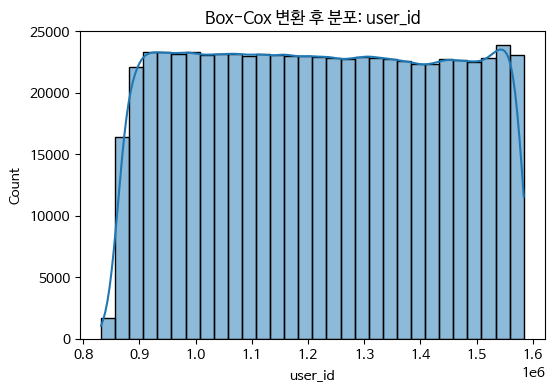

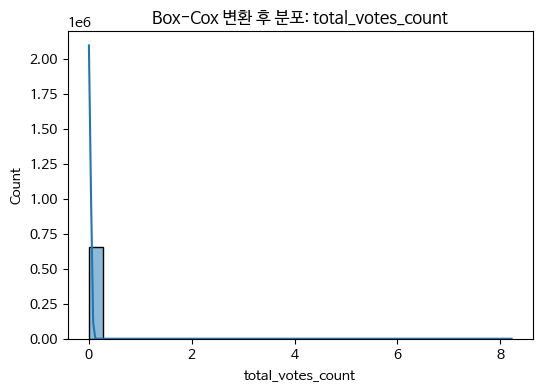

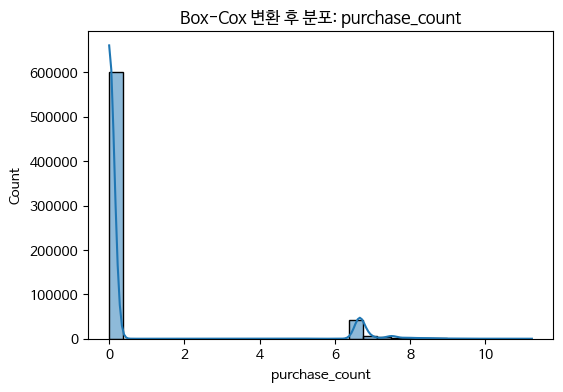

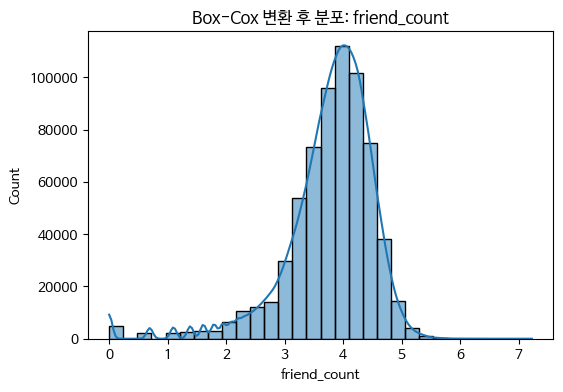

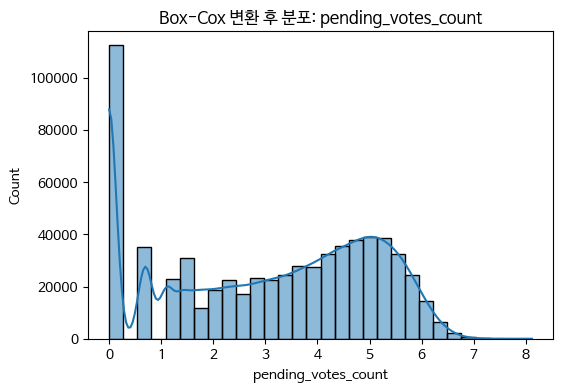

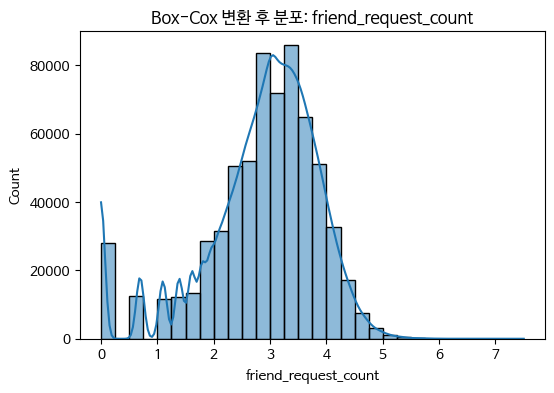

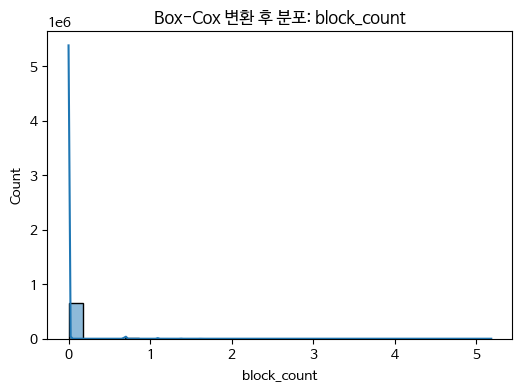

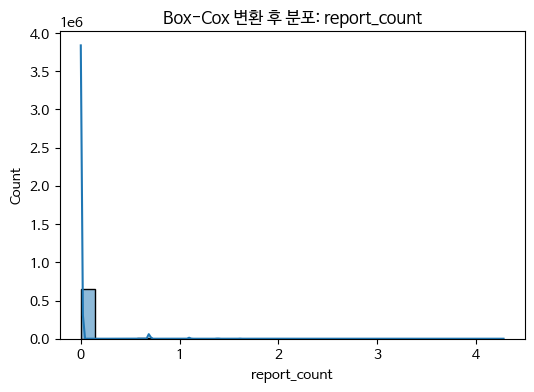

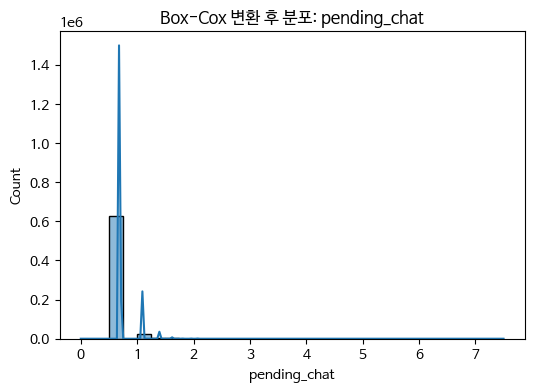

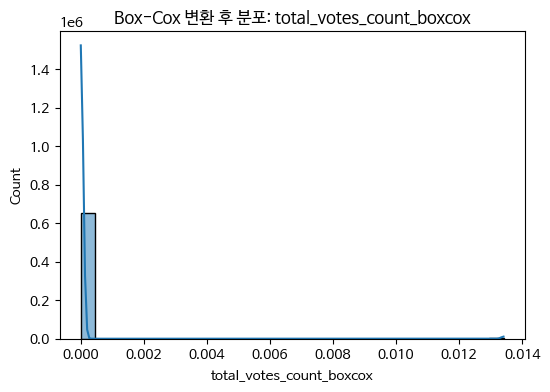

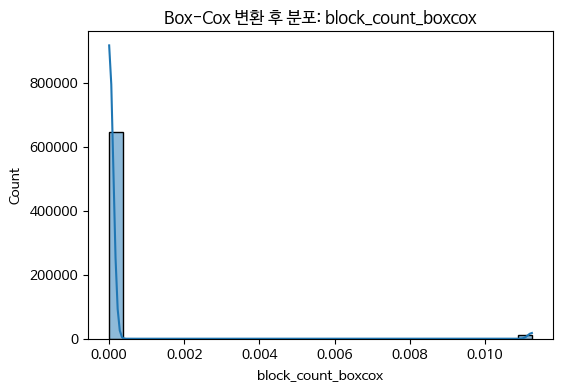

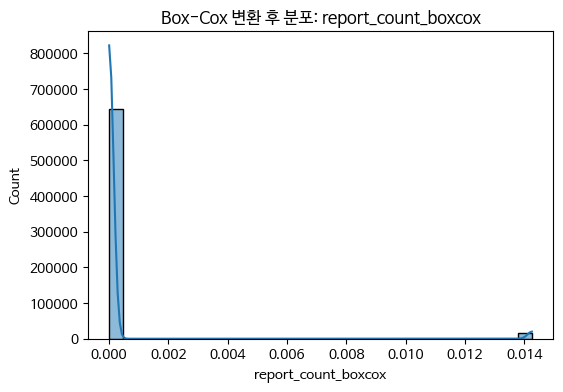

In [276]:
for col in cluster_df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(cluster_df[col], kde=True, bins=30)
    plt.title(f"Box-Cox 변환 후 분포: {col}")
    plt.show()

In [277]:
from scipy.stats import shapiro, kstest

for col in cluster_df.columns:
    stat, p = shapiro(cluster_df[col])  # Shapiro-Wilk 검정
    print(f"{col}: Shapiro-Wilk p-value = {p:.4f}")

    stat, p = kstest(cluster_df[col], 'norm')  # Kolmogorov-Smirnov 검정
    print(f"{col}: KS Test p-value = {p:.4f}\n")

/Users/hayechoi/Library/Python/3.13/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 660124.
  res = hypotest_fun_out(*samples, **kwds)


user_id: Shapiro-Wilk p-value = 0.0000
user_id: KS Test p-value = 0.0000

total_votes_count: Shapiro-Wilk p-value = 0.0000
total_votes_count: KS Test p-value = 0.0000

purchase_count: Shapiro-Wilk p-value = 0.0000
purchase_count: KS Test p-value = 0.0000

friend_count: Shapiro-Wilk p-value = 0.0000
friend_count: KS Test p-value = 0.0000

pending_votes_count: Shapiro-Wilk p-value = 0.0000
pending_votes_count: KS Test p-value = 0.0000

friend_request_count: Shapiro-Wilk p-value = 0.0000
friend_request_count: KS Test p-value = 0.0000

block_count: Shapiro-Wilk p-value = 0.0000
block_count: KS Test p-value = 0.0000

report_count: Shapiro-Wilk p-value = 0.0000
report_count: KS Test p-value = 0.0000

pending_chat: Shapiro-Wilk p-value = 0.0000
pending_chat: KS Test p-value = 0.0000

total_votes_count_boxcox: Shapiro-Wilk p-value = 0.0000
total_votes_count_boxcox: KS Test p-value = 0.0000

block_count_boxcox: Shapiro-Wilk p-value = 0.0000
block_count_boxcox: KS Test p-value = 0.0000

report_c

In [278]:
for col in cluster_df.columns:
    if col in cluster_df.columns:
        stat, p = shapiro(cluster_df[col])  # Shapiro-Wilk 검정
        print(f"{col}: Shapiro-Wilk p-value = {p:.4f}")

        stat, p = kstest(cluster_df[col], 'norm')  # Kolmogorov-Smirnov 검정
        print(f"{col}: KS Test p-value = {p:.4f}\n")
    else:
        print(f"⚠️ {col} 컬럼이 데이터프레임에 없음!")

user_id: Shapiro-Wilk p-value = 0.0000
user_id: KS Test p-value = 0.0000

total_votes_count: Shapiro-Wilk p-value = 0.0000
total_votes_count: KS Test p-value = 0.0000

purchase_count: Shapiro-Wilk p-value = 0.0000
purchase_count: KS Test p-value = 0.0000

friend_count: Shapiro-Wilk p-value = 0.0000
friend_count: KS Test p-value = 0.0000

pending_votes_count: Shapiro-Wilk p-value = 0.0000
pending_votes_count: KS Test p-value = 0.0000

friend_request_count: Shapiro-Wilk p-value = 0.0000
friend_request_count: KS Test p-value = 0.0000

block_count: Shapiro-Wilk p-value = 0.0000
block_count: KS Test p-value = 0.0000

report_count: Shapiro-Wilk p-value = 0.0000
report_count: KS Test p-value = 0.0000

pending_chat: Shapiro-Wilk p-value = 0.0000
pending_chat: KS Test p-value = 0.0000

total_votes_count_boxcox: Shapiro-Wilk p-value = 0.0000
total_votes_count_boxcox: KS Test p-value = 0.0000

block_count_boxcox: Shapiro-Wilk p-value = 0.0000
block_count_boxcox: KS Test p-value = 0.0000

report_c

In [279]:
cluster_df['total_votes_count_sqrt'] = np.sqrt(cluster_df['total_votes_count_boxcox'])
cluster_df['block_count_sqrt'] = np.sqrt(cluster_df['block_count_boxcox'])
cluster_df['report_count_sqrt'] = np.sqrt(cluster_df['report_count_boxcox'])

In [280]:
# 숫자형 컬럼만 선택
numeric_cols = cluster_df.select_dtypes(include=['number']).columns

# 각 컬럼별 왜도 계산
skewness = cluster_df[numeric_cols].apply(skew, nan_policy='omit')

# 결과 출력
print(skewness)

user_id                      0.010164
total_votes_count           12.340019
purchase_count               2.912291
friend_count                -1.672785
pending_votes_count         -0.217112
friend_request_count        -0.957036
block_count                  9.713329
report_count                 8.456023
pending_chat                 6.920090
total_votes_count_boxcox    11.817108
block_count_boxcox           7.020683
report_count_boxcox          6.269125
total_votes_count_sqrt      11.817108
block_count_sqrt             7.020683
report_count_sqrt            6.269125
dtype: float64


In [282]:
from sklearn.preprocessing import PowerTransformer

# Yeo-Johnson 변환 적용
pt = PowerTransformer(method='yeo-johnson')  
cluster_df[['total_votes_count_yj', 'block_count_yj', 'report_count_yj']] = pt.fit_transform(
    cluster_df[['total_votes_count_boxcox', 'block_count_boxcox', 'report_count_boxcox']]
)

# 변환 후 왜도 확인
print(cluster_df[['total_votes_count_yj', 'block_count_yj', 'report_count_yj']].skew())

total_votes_count_yj    11.817135
block_count_yj           7.020699
report_count_yj          6.269139
dtype: float64


In [283]:
# 숫자형 컬럼만 선택
numeric_cols = cluster_df.select_dtypes(include=['number']).columns

# 각 컬럼별 왜도 계산
skewness = cluster_df[numeric_cols].apply(skew, nan_policy='omit')

# 결과 출력
print(skewness)

user_id                      0.010164
total_votes_count           12.340019
purchase_count               2.912291
friend_count                -1.672785
pending_votes_count         -0.217112
friend_request_count        -0.957036
block_count                  9.713329
report_count                 8.456023
pending_chat                 6.920090
total_votes_count_boxcox    11.817108
block_count_boxcox           7.020683
report_count_boxcox          6.269125
total_votes_count_sqrt      11.817108
block_count_sqrt             7.020683
report_count_sqrt            6.269125
total_votes_count_yj        11.817108
block_count_yj               7.020683
report_count_yj              6.269125
dtype: float64


In [284]:
from sklearn.preprocessing import PowerTransformer

# Yeo-Johnson 변환 적용
pt = PowerTransformer(method='yeo-johnson')  
cluster_df[['total_votes_count_yj', 'block_count_yj', 'report_count_yj']] = pt.fit_transform(
    cluster_df[['total_votes_count_boxcox', 'block_count_boxcox', 'report_count_boxcox']]
)

# 변환 후 왜도 확인
print(cluster_df[['total_votes_count_yj', 'block_count_yj', 'report_count_yj']].skew())

total_votes_count_yj    11.817135
block_count_yj           7.020699
report_count_yj          6.269139
dtype: float64


### 이상치 확인

In [285]:
# 컬럼 이름에 'sqrt'가 포함된 컬럼들 찾기
columns_to_drop = [col for col in cluster_df.columns if 'sqrt' in col]

# 해당 컬럼들 삭제
cluster_df = cluster_df.drop(columns=columns_to_drop)


In [286]:
# 컬럼 이름에 'yj'가 포함된 컬럼들 찾기
columns_to_drop = [col for col in cluster_df.columns if 'yj' in col]

# 해당 컬럼들 삭제
cluster_df = cluster_df.drop(columns=columns_to_drop)

In [287]:
cluster_df.drop(['total_votes_count', 'block_count', 'report_count'], axis=1, inplace=True)

In [288]:
cluster_df.rename(columns = {'total_votes_count_boxcox' : 'total_votes_count', 'block_count_boxcox' : 'block_count', 'report_count_boxcox' : 'report_count'}, inplace=True)
cluster_df.tail()

,user_id,purchase_count,friend_count,pending_votes_count,friend_request_count,pending_chat,total_votes_count,block_count,report_count
660119,1583729,0.0,0.000000,0.0,0.000000,0.693147,0.0,0.0,0.0
660120,1583730,0.0,3.091042,0.0,3.044522,0.693147,0.0,0.0,0.0
660121,1583731,0.0,1.098612,0.0,0.693147,0.693147,0.0,0.0,0.0
660122,1583732,0.0,1.386294,0.0,1.386294,0.693147,0.0,0.0,0.0
660123,1583733,0.0,0.000000,0.0,0.000000,0.693147,0.0,0.0,0.0


In [289]:
cluster_df.columns

Index(['user_id', 'purchase_count', 'friend_count', 'pending_votes_count',
       'friend_request_count', 'pending_chat', 'total_votes_count',
       'block_count', 'report_count'],
      dtype='object')

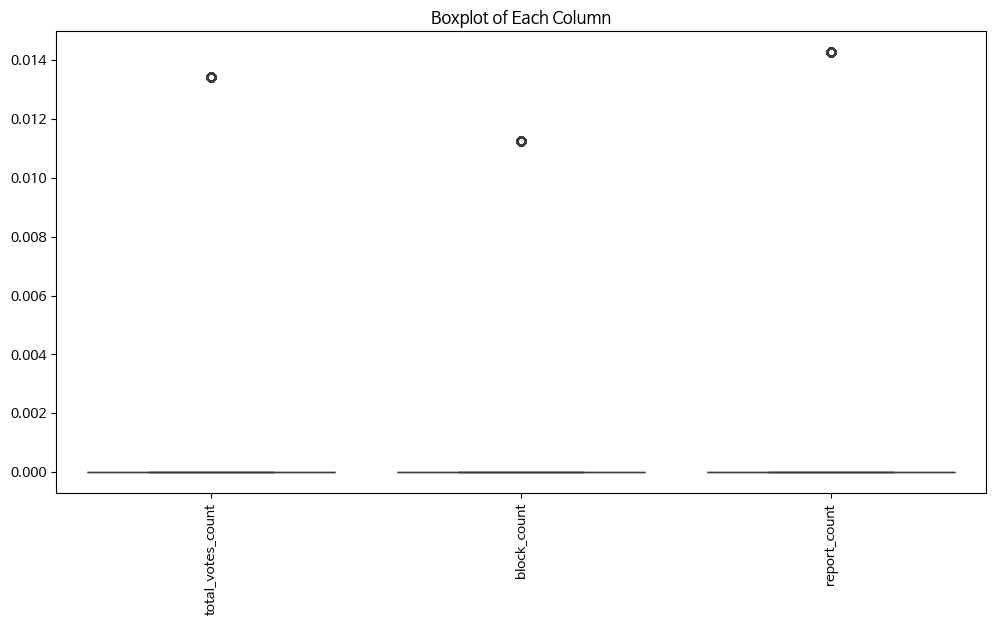

In [290]:
data = cluster_df[['total_votes_count', 'block_count', 'report_count']] 

plt.figure(figsize=(12, 6))
sns.boxplot(data=data)
plt.xticks(rotation=90)  # 컬럼 이름이 많을 경우 회전시켜서 보이게 함
plt.title('Boxplot of Each Column')
plt.show()

- 값들이 이상치들빼고 다 0인 경우이다.

In [291]:
cluster_df.query('total_votes_count > 0.04').shape[0] / cluster_df.shape[0] * 100

0.0

In [292]:
cluster_df.query('block_count > 0.01').shape[0] / cluster_df.shape[0] * 100

1.9131254128012314

In [293]:
cluster_df.query('report_count > 0.01').shape[0] / cluster_df.shape[0] * 100

2.3653131835836905

In [294]:
# 숫자형 컬럼만 선택
numeric_cols = cluster_df.select_dtypes(include=['number']).columns

# 각 컬럼별 왜도 계산
skewness = cluster_df[numeric_cols].apply(skew, nan_policy='omit')

# 결과 출력
print(skewness)

user_id                  0.010164
purchase_count           2.912291
friend_count            -1.672785
pending_votes_count     -0.217112
friend_request_count    -0.957036
pending_chat             6.920090
total_votes_count       11.817108
block_count              7.020683
report_count             6.269125
dtype: float64


In [295]:
cluster_df_test = cluster_df.copy()

In [296]:
# 로버스터 스케일링 적용
from sklearn.preprocessing import RobustScaler

# 데이터프레임에서 변환할 컬럼 선택
data = cluster_df_test[['total_votes_count', 'block_count', 'report_count']]

# RobustScaler 객체 생성
scaler = RobustScaler()

# 로버스트 스케일링 적용
scaled_data = scaler.fit_transform(data)

# 결과를 데이터프레임으로 변환
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)

# 원본 데이터프레임에 스케일링된 데이터 추가
cluster_df_test[['your_column1_scaled', 'your_column2_scaled', 'your_column3_scaled']] = scaled_df


In [297]:
# 숫자형 컬럼만 선택
numeric_cols = cluster_df_test.select_dtypes(include=['number']).columns

# 각 컬럼별 왜도 계산
skewness = cluster_df_test[numeric_cols].apply(skew, nan_policy='omit')

# 결과 출력
print(skewness)

user_id                  0.010164
purchase_count           2.912291
friend_count            -1.672785
pending_votes_count     -0.217112
friend_request_count    -0.957036
pending_chat             6.920090
total_votes_count       11.817108
block_count              7.020683
report_count             6.269125
your_column1_scaled     11.817108
your_column2_scaled      7.020683
your_column3_scaled      6.269125
dtype: float64


In [298]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 'cluster'와 'user_id' 열 제거
X = cluster_df.drop(columns=['user_id'])

# 상수항 추가 (절편을 포함해야 정확한 VIF 계산 가능)
X['Intercept'] = 1  

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
print(vif_data)

                Feature        VIF
0        purchase_count   1.012150
1          friend_count   2.273688
2   pending_votes_count   1.222129
3  friend_request_count   1.962584
4          pending_chat   1.008100
5     total_votes_count   1.000366
6           block_count   1.004413
7          report_count   1.008775
8             Intercept  57.517081


## 변수 중요도 가중치 클러스터링

#### k-means

In [299]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)  # 2차원으로 축소
clustering_pca = pca.fit_transform(cluster_df.drop(columns=["user_id"]))  # user_id 제외

print(f"PCA 설명력: {np.cumsum(pca.explained_variance_ratio_)}")

PCA 설명력: [0.44006677 0.84679586 0.97786095 0.99845986]


In [300]:
# PCA
pca = PCA(n_components=6)
pca.fit(cluster_df)
scaled_df_pc = pca.transform(cluster_df)
pca_df = pd.DataFrame(scaled_df_pc)

In [301]:
pca_df.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-390321.532714,-3.901935,-2.767312,-3.000007,-2.109442,0.037316
1,-389259.532714,-3.861272,-2.721547,-2.655825,-2.314725,0.036334
2,-389242.532711,-8.022249,5.147903,-4.247535,-1.863926,0.029602
3,-389129.532714,-3.671917,-2.499568,-0.964373,-3.326447,0.031680
4,-388989.532714,-3.663372,-2.489797,-0.890510,-3.370551,0.031472


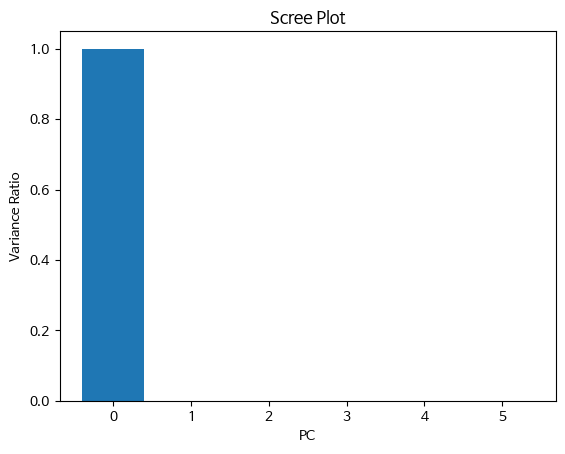

In [302]:
# 주성분의 설명력 확인
num_components = len(pca.explained_variance_ratio_)

x = np.arange(num_components)
var = pca.explained_variance_ratio_

# Scree Plot 시각화
plt.bar(x, var)
plt.xlabel('PC')
plt.ylabel('Variance Ratio')
plt.title('Scree Plot')

plt.show()

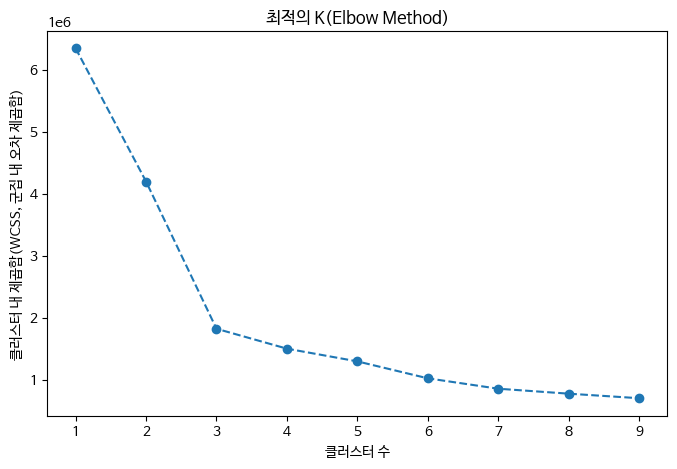

In [303]:
wcss = []
for i in range(1, 10):  # 1~10개 클러스터 실험
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(clustering_pca)
    wcss.append(kmeans.inertia_)  # 군집 내 분산 값 저장

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), wcss, marker="o", linestyle="--")
plt.xlabel("클러스터 수")
plt.ylabel("클러스터 내 제곱합(WCSS, 군집 내 오차 제곱합)")
plt.title("최적의 K(Elbow Method)")
plt.show()

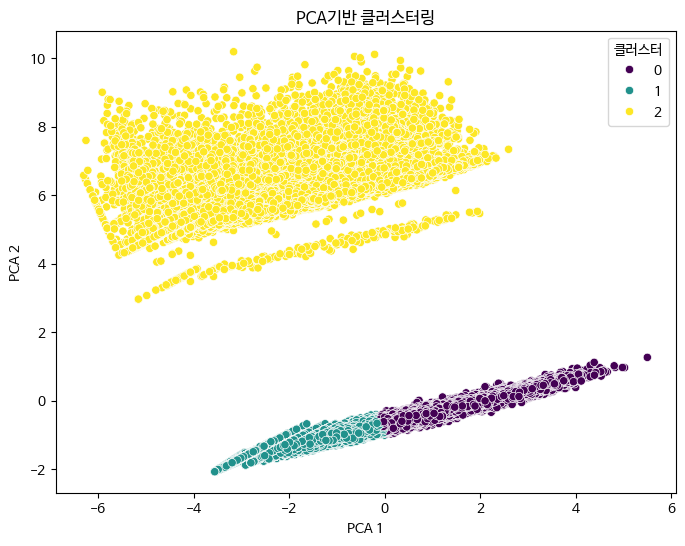

In [304]:
# PCA 변환
pca = PCA(n_components=2)
clustering_pca = pca.fit_transform(cluster_df.drop(columns=["user_id"]))  # user_id 제외

# K-Means 클러스터링 (클러스터 개수는 3개로 가정)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_df["cluster"] = kmeans.fit_predict(clustering_pca)

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=clustering_pca[:, 0], y=clustering_pca[:, 1], hue=cluster_df["cluster"], palette="viridis")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA기반 클러스터링")
plt.legend(title="클러스터")
plt.show()

In [305]:
# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df.drop(columns=['user_id'])) 

# PCA 적용
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 주성분 계수 확인
loadings = pd.DataFrame(pca.components_, columns=cluster_df.columns[1:], index=['PC1', 'PC2'])
loadings

,purchase_count,friend_count,pending_votes_count,friend_request_count,pending_chat,total_votes_count,block_count,report_count,cluster
PC1,0.280895,-0.471406,-0.508924,-0.368472,-0.078993,-0.019341,-0.00518,-0.049769,0.543121
PC2,0.559052,0.452788,-0.044693,0.496051,0.113953,0.016528,0.11391,0.150791,0.430591


In [306]:
cluster_df['cluster'].value_counts()

cluster
0    346398
1    254534
2     59192
Name: count, dtype: int64

In [307]:
# 데이터에서 10000개의 샘플 무작위로 선택
sample_df = cluster_df.sample(n=50000, random_state=42)
silhouette_df = sample_df.drop(['user_id', 'cluster'], axis=1)

# 실루엣 계수 계산
silhouette_kmeans = silhouette_score(silhouette_df, sample_df['cluster'])
print(f'K-Means Silhouette Score for Sampled Data: {silhouette_kmeans}')

K-Means Silhouette Score for Sampled Data: 0.5020209349187014


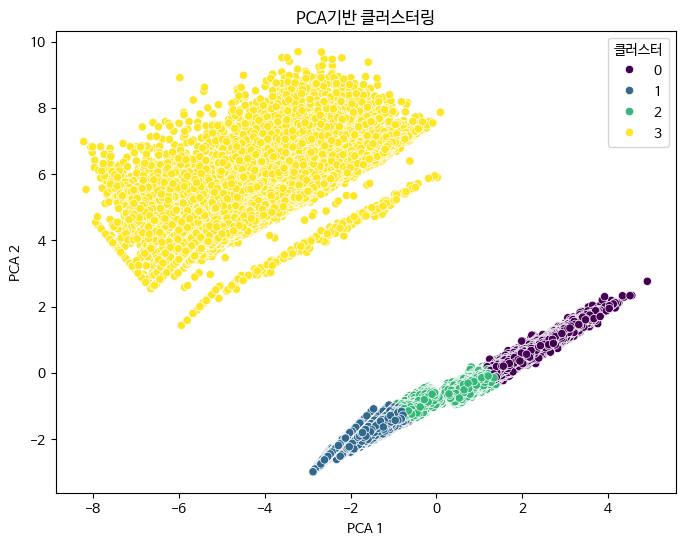

In [308]:
# PCA 변환
pca = PCA(n_components=2)
clustering_pca = pca.fit_transform(cluster_df.drop(columns=["user_id"]))  # user_id 제외

# K-Means 클러스터링 (클러스터 개수는 4개로 가정)
kmeans2 = KMeans(n_clusters=4, random_state=42)
cluster_df["cluster2"] = kmeans2.fit_predict(clustering_pca)

# 시각화
plt.figure(figsize=(8, 6))
sns.scatterplot(x=clustering_pca[:, 0], y=clustering_pca[:, 1], hue=cluster_df["cluster2"], palette="viridis")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA기반 클러스터링")
plt.legend(title="클러스터")
plt.show()

In [309]:
# 데이터 표준화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_df.drop(columns=["user_id"]))  # user_id 제외

# PCA 적용
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 주성분 계수 확인
loadings = pd.DataFrame(pca.components_, columns=cluster_df.columns[1:], index=['PC1', 'PC2'])
loadings

,purchase_count,friend_count,pending_votes_count,friend_request_count,pending_chat,total_votes_count,block_count,report_count,cluster,cluster2
PC1,0.402279,-0.269329,-0.416818,-0.179171,-0.035212,-0.011544,0.014838,-0.010070,0.558371,0.496307
PC2,0.400067,0.594589,0.178164,0.586657,0.133474,0.022571,0.094586,0.147297,0.161437,0.188338


In [310]:
cluster_df['cluster2'].value_counts()

cluster2
0    241295
1    188061
2    171576
3     59192
Name: count, dtype: int64

In [311]:
# 데이터에서 10000개의 샘플 무작위로 선택
sample_df = cluster_df.sample(n=50000, random_state=42)
silhouette_df = sample_df.drop(['user_id', 'cluster', 'cluster2'], axis=1)

# 실루엣 계수 계산
silhouette_kmeans = silhouette_score(silhouette_df, sample_df['cluster2'])
print(f'K-Means Silhouette Score for Sampled Data: {silhouette_kmeans}')

K-Means Silhouette Score for Sampled Data: 0.375592303947585


### 모델별 중요도 확인

In [312]:
# 모델 정의
models = {
    "Decision Tree": DecisionTreeClassifier(
                        max_depth=2,            # 트리의 최대 깊이 (과적합 방지)
                        min_samples_split=30,   # 노드를 나누는 최소 샘플 수
                        min_samples_leaf=10,    # 리프 노드의 최소 샘플 수
                        random_state=42
                    ),
    "Random Forest": RandomForestClassifier(
						n_estimators=10,        # 트리 개수 (적절한 값으로 조정)
						max_depth=2,            # 트리의 최대 깊이 (값을 낮추면 과적합 방지)
						min_samples_split=30,    # 내부 노드를 나누는 최소 샘플 수 (값을 증가)
						min_samples_leaf=10,      # 리프 노드의 최소 샘플 수 (값을 증가)
						random_state=42
					),
    "AdaBoost": AdaBoostClassifier(
                        n_estimators=10,        # 부스팅 반복 횟수 (적절한 값으로 조정)
                        learning_rate=0.1,      # 학습률 (값을 줄이면 안정적이지만 느려짐)
                        random_state=42
                    ),
    "XGBoost": XGBClassifier(
						eval_metric='mlogloss',
						objective='multi:softmax',
						max_depth=2,             # 깊이를 줄여서 과적합 방지
						learning_rate=0.1,      # 학습률 감소 (디폴트: 0.1)
						reg_alpha=0.1,           # L1 정규화 (Lasso, 불필요한 특성 제거)
						reg_lambda=1.0,          # L2 정규화 (Ridge, 모델 가중치 축소)
						n_estimators=10,
						random_state=42
					),
    "LightGBM": LGBMClassifier(
                        num_leaves=31,          # 리프 개수 (값이 높을수록 모델 복잡도 증가)
                        max_depth=2,            # 최대 깊이 (과적합 방지)
                        learning_rate=0.1,      # 학습률 조정
                        n_estimators=10,       # 트리 개수
                        reg_alpha=0.1,          # L1 정규화
                        reg_lambda=1.0,         # L2 정규화
                        random_state=42
					)
}

### Decision Tree

In [313]:
X = cluster_df.drop(['user_id', 'cluster', 'cluster2'], axis=1)
y = cluster_df['cluster']

In [314]:
# 데이터 분리 (X, y는 사용자가 정의한 데이터셋으로 대체)
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42, stratify=y)

In [315]:
# 모델 정의
models = {
    "Decision Tree": DecisionTreeClassifier(
                        max_depth=2,            # 트리의 최대 깊이 (과적합 방지)
                        min_samples_split=30,   # 노드를 나누는 최소 샘플 수
                        min_samples_leaf=10,    # 리프 노드의 최소 샘플 수
                        random_state=42
                    )
}

In [316]:
# 교차검증 설정
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [317]:
# 각 모델의 교차검증 점수 저장
cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall_weighted')
    cv_results[model_name] = scores.mean()

# 결과 출력
print("모델별 교차검증 평균 점수:")
for model_name, score in cv_results.items():
    print(f"{model_name}: {score:.4f}")

# 가장 성능이 높은 모델 찾기
best_model_name = max(cv_results, key=cv_results.get)
best_model_score = cv_results[best_model_name]
print(f"\n가장 recall_score 성능이 높은 모델: {best_model_name} (교차검증 점수: {best_model_score:.4f})")

모델별 교차검증 평균 점수:
Decision Tree: 0.9793

가장 recall_score 성능이 높은 모델: Decision Tree (교차검증 점수: 0.9793)


In [318]:
# 최적 모델을 테스트 데이터에 평가
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)

# 다중 클래스 분류 평가
print("\n최적 모델의 성능 평가:")
print(classification_report(y_test, y_pred))
print(f"\n최적 모델의 테스트 데이터 점수: {test_score:.4f}")


최적 모델의 성능 평가:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     69280
           1       0.98      0.97      0.97     50907
           2       1.00      1.00      1.00     11838

    accuracy                           0.98    132025
   macro avg       0.98      0.98      0.98    132025
weighted avg       0.98      0.98      0.98    132025


최적 모델의 테스트 데이터 점수: 0.9797


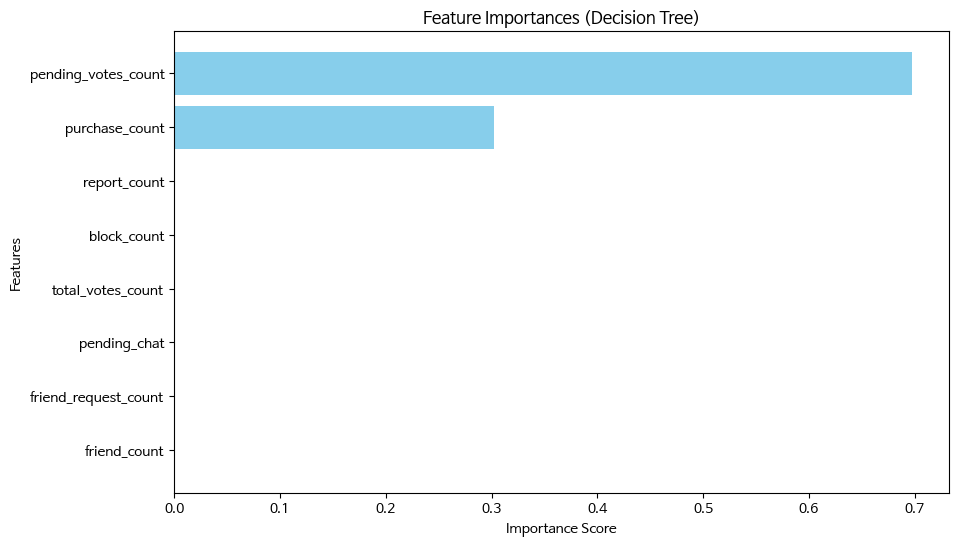

In [319]:
# 최적 모델 학습
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# 최적 모델의 Feature Importances 확인 및 시각화
if hasattr(best_model, "feature_importances_"):
    feature_importances = best_model.feature_importances_

    # 시각화
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importances)[::-1]  # 중요도 순서로 정렬
    features = np.array(X_train.columns)[indices] if hasattr(X_train, "columns") else indices  # 특성 이름 확인
    importances = feature_importances[indices]

    plt.barh(features, importances, align='center', color='skyblue')
    plt.gca().invert_yaxis()  # 높은 값이 위로 오도록 설정
    plt.title(f"Feature Importances ({best_model_name})")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()
else:
    print(f"{best_model_name} 모델은 feature_importances_ 속성을 지원하지 않습니다.")

### Random Forest

In [320]:
X = cluster_df.drop(['user_id', 'cluster', 'cluster2'], axis=1)
y = cluster_df['cluster']

In [321]:
# 데이터 분리 (X, y는 사용자가 정의한 데이터셋으로 대체)
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42, stratify=y)

In [322]:
# 모델 정의
models = {
    "Random Forest": RandomForestClassifier(
						n_estimators=10,        # 트리 개수 (적절한 값으로 조정)
						max_depth=2,            # 트리의 최대 깊이 (값을 낮추면 과적합 방지)
						min_samples_split=30,    # 내부 노드를 나누는 최소 샘플 수 (값을 증가)
						min_samples_leaf=10,      # 리프 노드의 최소 샘플 수 (값을 증가)
						random_state=42
					)
}

In [323]:
# 교차검증 설정
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [324]:
# 각 모델의 교차검증 점수 저장
cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall_weighted')
    cv_results[model_name] = scores.mean()

# 결과 출력
print("모델별 교차검증 평균 점수:")
for model_name, score in cv_results.items():
    print(f"{model_name}: {score:.4f}")

# 가장 성능이 높은 모델 찾기
best_model_name = max(cv_results, key=cv_results.get)
best_model_score = cv_results[best_model_name]
print(f"\n가장 recall_score 성능이 높은 모델: {best_model_name} (교차검증 점수: {best_model_score:.4f})")

모델별 교차검증 평균 점수:
Random Forest: 0.9375

가장 recall_score 성능이 높은 모델: Random Forest (교차검증 점수: 0.9375)


In [325]:
# 최적 모델을 테스트 데이터에 평가
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)

# 다중 클래스 분류 평가
print("\n최적 모델의 성능 평가:")
print(classification_report(y_test, y_pred))
print(f"\n최적 모델의 테스트 데이터 점수: {test_score:.4f}")


최적 모델의 성능 평가:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     69280
           1       0.88      0.97      0.92     50907
           2       1.00      0.53      0.69     11838

    accuracy                           0.94    132025
   macro avg       0.95      0.83      0.87    132025
weighted avg       0.94      0.94      0.93    132025


최적 모델의 테스트 데이터 점수: 0.9375


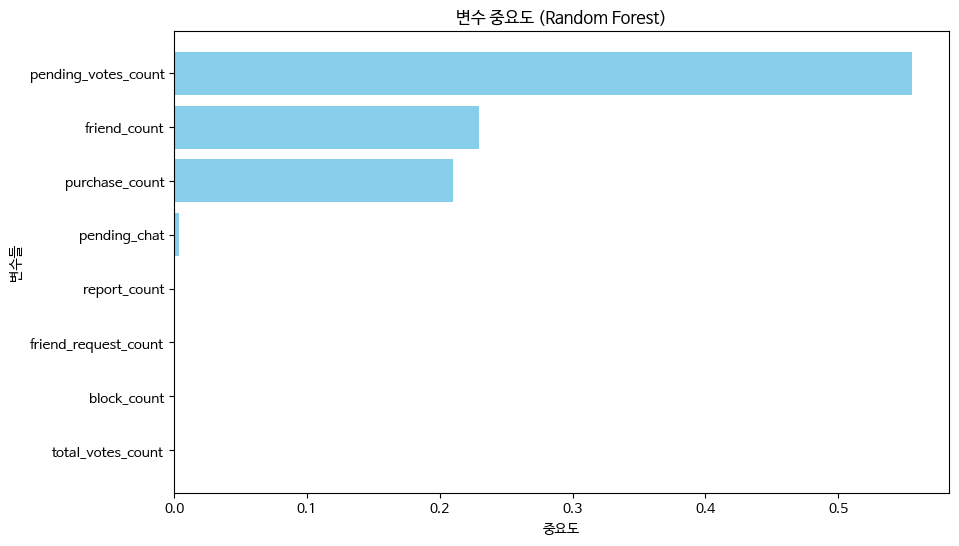

In [326]:
# 최적 모델 학습
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# 최적 모델의 Feature Importances 확인 및 시각화
if hasattr(best_model, "feature_importances_"):
    feature_importances = best_model.feature_importances_

    # 시각화
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importances)[::-1]  # 중요도 순서로 정렬
    features = np.array(X_train.columns)[indices] if hasattr(X_train, "columns") else indices  # 특성 이름 확인
    importances = feature_importances[indices]

    plt.barh(features, importances, align='center', color='skyblue')
    plt.gca().invert_yaxis()  # 높은 값이 위로 오도록 설정
    plt.title(f"변수 중요도 ({best_model_name})")
    plt.xlabel("중요도")
    plt.ylabel("변수들")
    plt.show()
else:
    print(f"{best_model_name} 모델은 feature_importances_ 속성을 지원하지 않습니다.")

### Adaboost

In [327]:
X = cluster_df.drop(['user_id', 'cluster', 'cluster2'], axis=1)
y = cluster_df['cluster']

In [328]:
# 데이터 분리 (X, y는 사용자가 정의한 데이터셋으로 대체)
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42, stratify=y)

In [329]:
# 모델 정의
models = {
    "AdaBoost": AdaBoostClassifier(
                        n_estimators=10,        # 부스팅 반복 횟수 (적절한 값으로 조정)
                        learning_rate=0.1,      # 학습률 (값을 줄이면 안정적이지만 느려짐)
                        random_state=42
                    )
}

In [330]:
# 교차검증 설정
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [331]:
# 각 모델의 교차검증 점수 저장
cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall_weighted')
    cv_results[model_name] = scores.mean()

# 결과 출력
print("모델별 교차검증 평균 점수:")
for model_name, score in cv_results.items():
    print(f"{model_name}: {score:.4f}")

# 가장 성능이 높은 모델 찾기
best_model_name = max(cv_results, key=cv_results.get)
best_model_score = cv_results[best_model_name]
print(f"\n가장 recall_score 성능이 높은 모델: {best_model_name} (교차검증 점수: {best_model_score:.4f})")

모델별 교차검증 평균 점수:
AdaBoost: 0.8896

가장 recall_score 성능이 높은 모델: AdaBoost (교차검증 점수: 0.8896)


In [332]:
# 최적 모델을 테스트 데이터에 평가
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)

# 다중 클래스 분류 평가
print("\n최적 모델의 성능 평가:")
print(classification_report(y_test, y_pred))
print(f"\n최적 모델의 테스트 데이터 점수: {test_score:.4f}")


최적 모델의 성능 평가:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     69280
           1       0.88      0.97      0.92     50907
           2       0.00      0.00      0.00     11838

    accuracy                           0.89    132025
   macro avg       0.59      0.65      0.62    132025
weighted avg       0.81      0.89      0.85    132025


최적 모델의 테스트 데이터 점수: 0.8900


/Users/hayechoi/Library/Python/3.13/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hayechoi/Library/Python/3.13/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/hayechoi/Library/Python/3.13/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

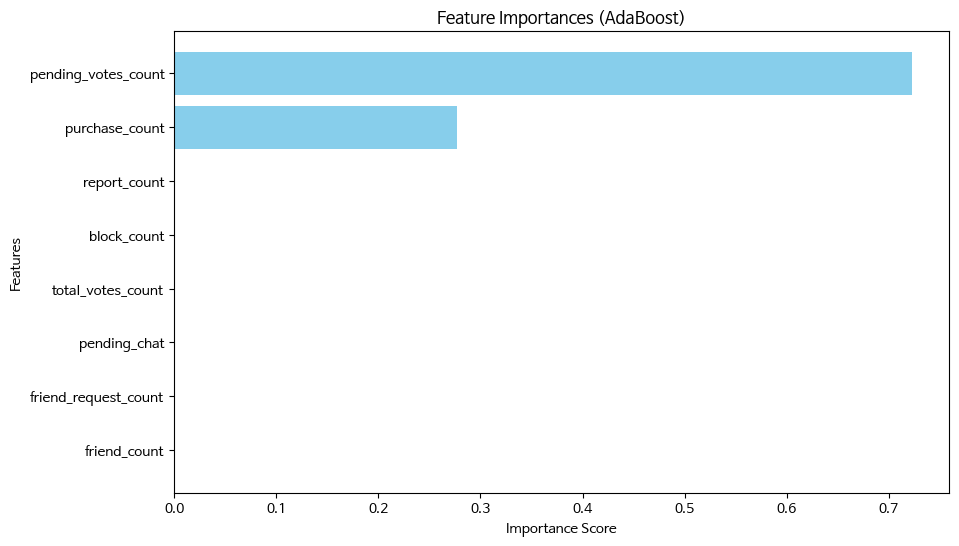

In [333]:
# 최적 모델 학습
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# 최적 모델의 Feature Importances 확인 및 시각화
if hasattr(best_model, "feature_importances_"):
    feature_importances = best_model.feature_importances_

    # 시각화
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importances)[::-1]  # 중요도 순서로 정렬
    features = np.array(X_train.columns)[indices] if hasattr(X_train, "columns") else indices  # 특성 이름 확인
    importances = feature_importances[indices]

    plt.barh(features, importances, align='center', color='skyblue')
    plt.gca().invert_yaxis()  # 높은 값이 위로 오도록 설정
    plt.title(f"Feature Importances ({best_model_name})")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()
else:
    print(f"{best_model_name} 모델은 feature_importances_ 속성을 지원하지 않습니다.")


### XGboost

In [334]:
X = cluster_df.drop(['user_id', 'cluster', 'cluster2'], axis=1)
y = cluster_df['cluster']

In [335]:
# 데이터 분리 (X, y는 사용자가 정의한 데이터셋으로 대체)
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42, stratify=y)

In [336]:
# 모델 정의
models = {
    "XGBoost": XGBClassifier(
						eval_metric='mlogloss',
						objective='multi:softmax',
						max_depth=2,             # 깊이를 줄여서 과적합 방지
						learning_rate=0.1,      # 학습률 감소 (디폴트: 0.1)
						reg_alpha=0.1,           # L1 정규화 (Lasso, 불필요한 특성 제거)
						reg_lambda=1.0,          # L2 정규화 (Ridge, 모델 가중치 축소)
						n_estimators=10,
						random_state=42
					)
}

In [337]:
# 교차검증 설정
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [338]:
# 각 모델의 교차검증 점수 저장
cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall_weighted')
    cv_results[model_name] = scores.mean()

# 결과 출력
print("모델별 교차검증 평균 점수:")
for model_name, score in cv_results.items():
    print(f"{model_name}: {score:.4f}")

# 가장 성능이 높은 모델 찾기
best_model_name = max(cv_results, key=cv_results.get)
best_model_score = cv_results[best_model_name]
print(f"\n가장 recall_score 성능이 높은 모델: {best_model_name} (교차검증 점수: {best_model_score:.4f})")

모델별 교차검증 평균 점수:
XGBoost: 0.9793

가장 recall_score 성능이 높은 모델: XGBoost (교차검증 점수: 0.9793)


In [339]:
# 최적 모델을 테스트 데이터에 평가
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)

# 다중 클래스 분류 평가
print("\n최적 모델의 성능 평가:")
print(classification_report(y_test, y_pred))
print(f"\n최적 모델의 테스트 데이터 점수: {test_score:.4f}")


최적 모델의 성능 평가:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     69280
           1       0.98      0.97      0.97     50907
           2       1.00      1.00      1.00     11838

    accuracy                           0.98    132025
   macro avg       0.98      0.98      0.98    132025
weighted avg       0.98      0.98      0.98    132025


최적 모델의 테스트 데이터 점수: 0.9797


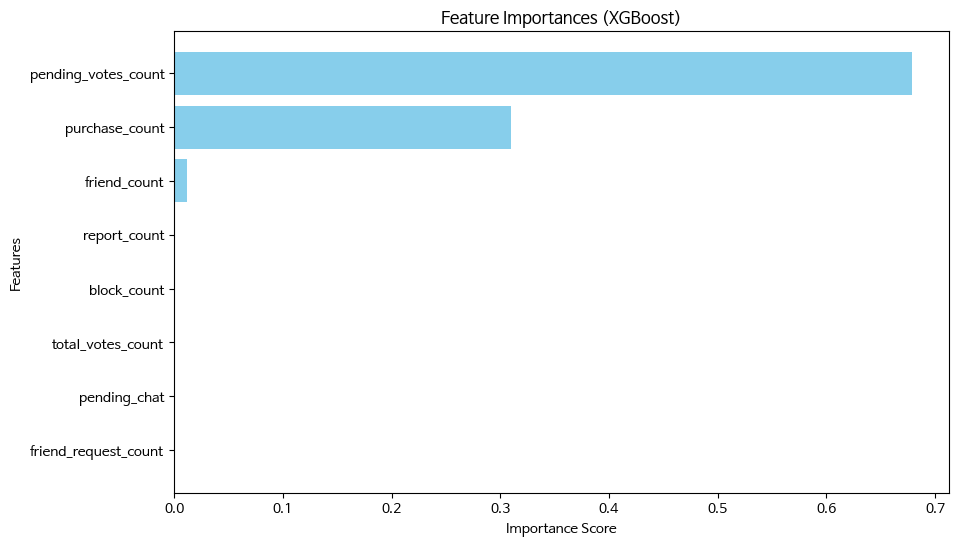

In [340]:
# 최적 모델 학습
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# 최적 모델의 Feature Importances 확인 및 시각화
if hasattr(best_model, "feature_importances_"):
    feature_importances = best_model.feature_importances_

    # 시각화
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importances)[::-1]  # 중요도 순서로 정렬
    features = np.array(X_train.columns)[indices] if hasattr(X_train, "columns") else indices  # 특성 이름 확인
    importances = feature_importances[indices]

    plt.barh(features, importances, align='center', color='skyblue')
    plt.gca().invert_yaxis()  # 높은 값이 위로 오도록 설정
    plt.title(f"Feature Importances ({best_model_name})")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()
else:
    print(f"{best_model_name} 모델은 feature_importances_ 속성을 지원하지 않습니다.")


### LightGBM

In [ ]:
X = cluster_df.drop(['user_id', 'cluster', 'cluster2'], axis=1)
y = cluster_df['cluster']

In [341]:
# 데이터 분리 (X, y는 사용자가 정의한 데이터셋으로 대체)
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42, stratify=y)

In [342]:
# 모델 정의
models = {
    "LightGBM": LGBMClassifier(
                        num_leaves=31,          # 리프 개수 (값이 높을수록 모델 복잡도 증가)
                        max_depth=2,            # 최대 깊이 (과적합 방지)
                        learning_rate=0.1,      # 학습률 조정
                        n_estimators=10,       # 트리 개수
                        reg_alpha=0.1,          # L1 정규화
                        reg_lambda=1.0,         # L2 정규화
                        random_state=42
					)
}

In [343]:
# 교차검증 설정
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [344]:
# 각 모델의 교차검증 점수 저장
cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall_weighted')
    cv_results[model_name] = scores.mean()

# 결과 출력
print("모델별 교차검증 평균 점수:")
for model_name, score in cv_results.items():
    print(f"{model_name}: {score:.4f}")

# 가장 성능이 높은 모델 찾기
best_model_name = max(cv_results, key=cv_results.get)
best_model_score = cv_results[best_model_name]
print(f"\n가장 recall_score 성능이 높은 모델: {best_model_name} (교차검증 점수: {best_model_score:.4f})")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 422479, number of used features: 8
[LightGBM] [Info] Start training from score -0.644842
[LightGBM] [Info] Start training from score -0.952991
[LightGBM] [Info] Start training from score -2.411637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [345]:
# 최적 모델을 테스트 데이터에 평가
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)

# 다중 클래스 분류 평가
print("\n최적 모델의 성능 평가:")
print(classification_report(y_test, y_pred))
print(f"\n최적 모델의 테스트 데이터 점수: {test_score:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 528099, number of used features: 8
[LightGBM] [Info] Start training from score -0.644840
[LightGBM] [Info] Start training from score -0.952994
[LightGBM] [Info] Start training from score -2.411632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 528099, number of used features: 8
[LightGBM] [Info] Start training from score -0.644840
[LightGBM] [Info] Start training from score -0.952994
[LightGBM] [Info] Start training from score -2.411632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

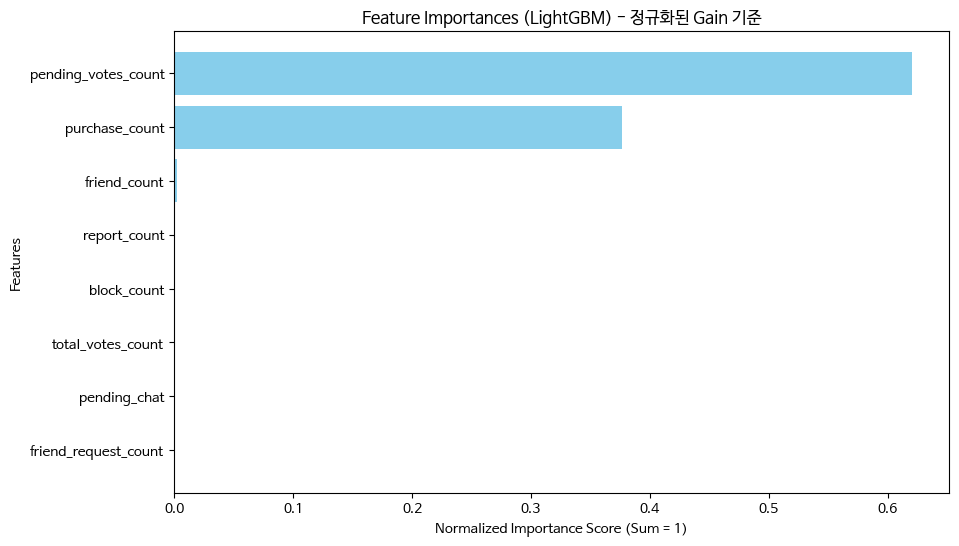

In [346]:
# 최적 모델 학습
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# 최적 모델의 Feature Importances 확인 및 시각화
if hasattr(best_model, "feature_importances_"):
    
    # LightGBM일 경우 Gain 기준으로 변수 중요도 가져오기
    if "lightgbm" in best_model_name.lower():
        raw_importances = best_model.booster_.feature_importance(importance_type="gain")
    else:
        raw_importances = best_model.feature_importances_

    # 중요도 정규화 (합이 1이 되도록)
    feature_importances = raw_importances / np.sum(raw_importances)

    # 시각화
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importances)[::-1]  # 중요도 순서로 정렬
    features = np.array(X_train.columns)[indices] if hasattr(X_train, "columns") else indices  # 특성 이름 확인
    importances = feature_importances[indices]

    plt.barh(features, importances, align='center', color='skyblue')
    plt.gca().invert_yaxis()  # 높은 값이 위로 오도록 설정
    plt.title(f"Feature Importances ({best_model_name}) - 정규화된 Gain 기준")
    plt.xlabel("Normalized Importance Score (Sum = 1)")
    plt.ylabel("Features")
    plt.show()
else:
    print(f"{best_model_name} 모델은 feature_importances_ 속성을 지원하지 않습니다.")


### 교차 검증

In [347]:
X = cluster_df.drop(['user_id', 'cluster'], axis=1)
y = cluster_df['cluster']

In [348]:
# 데이터 분리 (X, y는 사용자가 정의한 데이터셋으로 대체)
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42, stratify=y)

In [349]:
# 모델 정의
models = {
    "Random Forest": RandomForestClassifier(
						n_estimators=10,        # 트리 개수 (적절한 값으로 조정)
						max_depth=2,            # 트리의 최대 깊이 (값을 낮추면 과적합 방지)
						min_samples_split=30,    # 내부 노드를 나누는 최소 샘플 수 (값을 증가)
						min_samples_leaf=10,      # 리프 노드의 최소 샘플 수 (값을 증가)
						random_state=42
					)
}

In [350]:
# 교차검증 설정
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [351]:
# 각 모델의 교차검증 점수 저장
cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall_weighted')
    cv_results[model_name] = scores.mean()

# 결과 출력
print("모델별 교차검증 평균 점수:")
for model_name, score in cv_results.items():
    print(f"{model_name}: {score:.4f}")

# 가장 성능이 높은 모델 찾기
best_model_name = max(cv_results, key=cv_results.get)
best_model_score = cv_results[best_model_name]
print(f"\n가장 recall_score 성능이 높은 모델: {best_model_name} (교차검증 점수: {best_model_score:.4f})")

모델별 교차검증 평균 점수:
Random Forest: 0.9046

가장 recall_score 성능이 높은 모델: Random Forest (교차검증 점수: 0.9046)


In [352]:
# 최적 모델을 테스트 데이터에 평가
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)

# 다중 클래스 분류 평가
print("\n최적 모델의 성능 평가:")
print(classification_report(y_test, y_pred))
print(f"\n최적 모델의 테스트 데이터 점수: {test_score:.4f}")


최적 모델의 성능 평가:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     69280
           1       0.89      0.97      0.93     50907
           2       1.00      0.07      0.13     11838

    accuracy                           0.90    132025
   macro avg       0.93      0.67      0.67    132025
weighted avg       0.91      0.90      0.86    132025


최적 모델의 테스트 데이터 점수: 0.8963


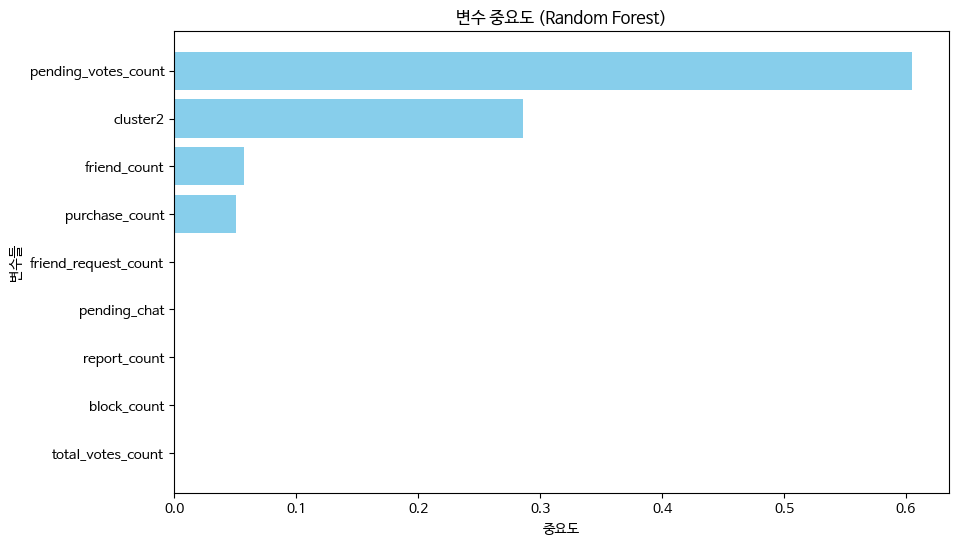

In [353]:
# 최적 모델 학습
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# 최적 모델의 Feature Importances 확인 및 시각화
if hasattr(best_model, "feature_importances_"):
    feature_importances = best_model.feature_importances_

    # 시각화
    plt.figure(figsize=(10, 6))
    indices = np.argsort(feature_importances)[::-1]  # 중요도 순서로 정렬
    features = np.array(X_train.columns)[indices] if hasattr(X_train, "columns") else indices  # 특성 이름 확인
    importances = feature_importances[indices]

    plt.barh(features, importances, align='center', color='skyblue')
    plt.gca().invert_yaxis()  # 높은 값이 위로 오도록 설정
    plt.title(f"변수 중요도 ({best_model_name})")
    plt.xlabel("중요도")
    plt.ylabel("변수들")
    plt.show()
else:
    print(f"{best_model_name} 모델은 feature_importances_ 속성을 지원하지 않습니다.")


### 변수 중요도 확인 후 가중치 정하기

- 예측 모델을 돌린 후 모델별 변수 중요도를 확인 했을 때 결과
    - 1st : pending_votes_count
    - 2nd : purchase_count
    - 3rd : friend_count
- RFM score 와 맞추기 위해 PPF score로 만들어서 비교해보기로 함
- 예측 모델 중 PPF 가중치를 둘 수 있는 Random Forest 와 XGboost 중에서 고민
- XGboost 는 friend_count 가 생각보다 낮게 나와 Random Forest 채택

- 가중치
    - pending_votes_count ⇒ 0.655
    - purchase_count ⇒ 0.21
    - friend_count ⇒ 0.133

### 가중치 곱하기

In [354]:
new_df = cluster_df[['user_id', 'pending_votes_count', 'purchase_count', 'friend_count']]

In [355]:
rf_p1 = 0.655
rf_p2 = 0.21
rf_f = 0.133

In [356]:
new_df['pending_votes_count'] = new_df['pending_votes_count'] * rf_p1
new_df['purchase_count'] = new_df['purchase_count'] * rf_p2
new_df['friend_count'] = new_df['friend_count'] * rf_f

/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/4161361103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['pending_votes_count'] = new_df['pending_votes_count'] * rf_p1
/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/4161361103.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['purchase_count'] = new_df['purchase_count'] * rf_p2
/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/4161361103.py:3: SettingWithCopyWarning: 
A value is trying t

### 클러스터링 진행

In [357]:
# 사용할 변수 선택
X = new_df[['pending_votes_count', 'purchase_count', 'friend_count']]

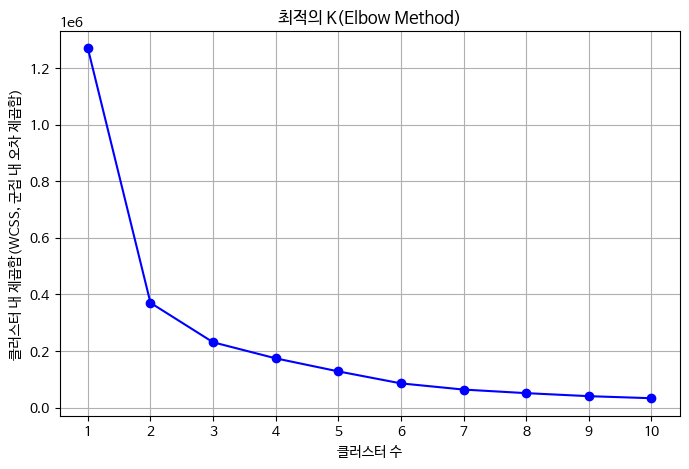

In [358]:
# 1. Elbow Method로 최적의 K 찾기
inertia = []
K_range = range(1, 11)  # 1~10개의 클러스터 개수를 실험

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)  # 각 K값에 대한 Inertia 저장

# Elbow Method 시각화
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='-', color='b')
plt.xlabel("클러스터 수")
plt.ylabel("클러스터 내 제곱합(WCSS, 군집 내 오차 제곱합)")
plt.title("최적의 K(Elbow Method)")
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [359]:
# 2. 최적의 클러스터 개수를 3개로 설정하여 KMeans 적용
optimal_k = 3  # elbow method를 보고 적절한 K로 변경 가능
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
new_df['cluster'] = kmeans.fit_predict(X)

/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/2011710606.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['cluster'] = kmeans.fit_predict(X)


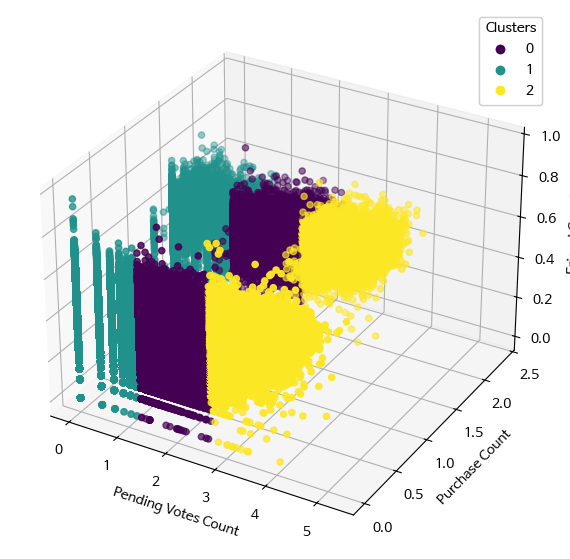

In [360]:
# 3. 3D 클러스터링 시각화
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 각 클러스터별로 색상 구분
scatter = ax.scatter(X['pending_votes_count'], X['purchase_count'], X['friend_count'], 
                      c=new_df['cluster'], cmap='viridis')

# 축 라벨 설정
ax.set_xlabel('Pending Votes Count')
ax.set_ylabel('Purchase Count')
ax.set_zlabel('Friend Count')

# 범례 추가
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# 그래프 표시
plt.show()

In [361]:
# 데이터에서 10000개의 샘플 무작위로 선택
sample_df = new_df.sample(n=50000, random_state=42)
silhouette_df = sample_df.drop(['user_id', 'cluster'], axis=1)

# 실루엣 계수 계산
silhouette_kmeans = silhouette_score(silhouette_df, sample_df['cluster'])
print(f'K-Means Silhouette Score for Sampled Data: {silhouette_kmeans}')

K-Means Silhouette Score for Sampled Data: 0.5211310315162064


In [362]:
# 2. 최적의 클러스터 개수를 4개로 설정하여 KMeans 적용
optimal_k = 4  # elbow method를 보고 적절한 K로 변경 가능
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
new_df['cluster2'] = kmeans.fit_predict(X)

/var/folders/_j/zyzv82h55bl4wg7kyhfh_gtm0000gn/T/ipykernel_40645/1813585568.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['cluster2'] = kmeans.fit_predict(X)


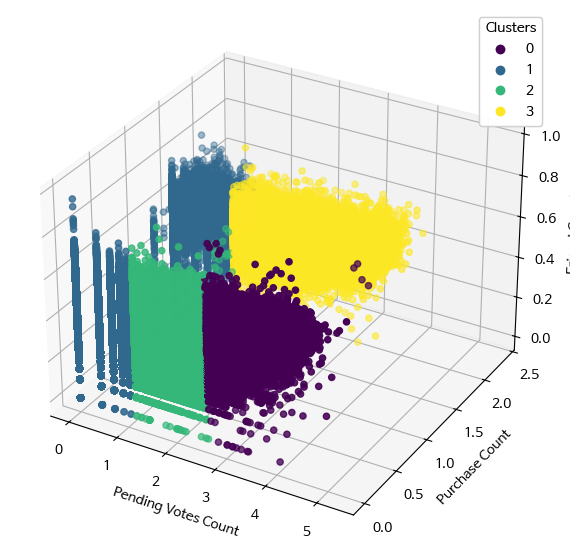

In [363]:
# 3. 3D 클러스터링 시각화
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# 각 클러스터별로 색상 구분
scatter = ax.scatter(X['pending_votes_count'], X['purchase_count'], X['friend_count'], 
                      c=new_df['cluster2'], cmap='viridis')

# 축 라벨 설정
ax.set_xlabel('Pending Votes Count')
ax.set_ylabel('Purchase Count')
ax.set_zlabel('Friend Count')

# 범례 추가
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# 그래프 표시
plt.show()

In [364]:
# 데이터에서 10000개의 샘플 무작위로 선택
sample_df = new_df.sample(n=50000, random_state=42)
silhouette_df = sample_df.drop(['user_id', 'cluster2'], axis=1)

# 실루엣 계수 계산
silhouette_kmeans = silhouette_score(silhouette_df, sample_df['cluster2'])
print(f'K-Means Silhouette Score for Sampled Data: {silhouette_kmeans}')

K-Means Silhouette Score for Sampled Data: 0.6377483701550504
